In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import pchip_interpolate, CloughTocher2DInterpolator, RectBivariateSpline
import scipy.stats as stats

plt.style.use('./custom_latex_style.mplstyle')

from datetime import datetime, timedelta
import seaborn as sns
sns.set_theme()

## Question 0

In [2]:
 # %% Question 0
 # Read the data with panda and transform them into nmupy array 
# Load the data using pandas
data = pd.read_csv('NORA10_5674N_0501E.txt', header=3, sep='\s+')

# Function to create a datetime from row data
def create_datetime(row):
    return pd.Timestamp(year=int(row[0]), month=int(row[1]), day=int(row[2]), hour=int(row[3]))

# Extract start and end times from the data
start_time = create_datetime(data.iloc[0])
end_time = create_datetime(data.iloc[-1])

# Create a time range
time= pd.date_range(start=start_time, end=end_time, freq='3H')


# Time steps in hours
time_step = 3
dt= time_step
num_points = len(time)
t = np.linspace(0, (num_points - 1) * time_step, num_points)

# Extract specific columns
oldU = data.iloc[:, 8:13]
oldDir = data.iloc[:, 13:16]

# Print the original data
print(data)

        YEAR   M   D   H    MSLP   T2m  RH2m   RR   W10   W50  ...    TP   TM  \
0       1957   9   1   6  1013.8  13.0  76.6  0.0   5.3   5.5  ...   5.2  4.5   
1       1957   9   1   9  1013.4  13.6  74.4  0.0   5.1   5.4  ...   5.2  4.6   
2       1957   9   1  12  1012.9  13.7  76.3  0.0   3.3   3.5  ...   5.2  4.7   
3       1957   9   1  15  1012.5  14.5  80.3  0.1   2.5   2.8  ...   5.2  4.7   
4       1957   9   1  18  1012.0  14.1  78.9  0.0   4.1   4.4  ...   5.2  4.7   
...      ...  ..  ..  ..     ...   ...   ...  ...   ...   ...  ...   ...  ...   
187728  2021  11  30   6   995.9   6.6  66.2  0.2  18.4  20.8  ...  10.2  7.8   
187729  2021  11  30   9   998.2   6.7  61.3  0.4  16.2  18.2  ...  10.2  8.1   
187730  2021  11  30  12   999.7   6.5  64.6  0.2  12.7  14.0  ...  11.2  8.0   
187731  2021  11  30  15  1000.2   6.6  56.9  0.1   8.1   8.7  ...  11.2  7.7   
187732  2021  11  30  18   999.6   6.1  56.8  0.0   4.5   4.8  ...  11.2  7.9   

         DIRP   DIRM  HS.1 

## Question 1

In [3]:
# %% Question 1
# We use the DTU 10 MW wind turbine with the hub heught of 119 m
zHub =  119 # hub height

oldZ = np.array([10, 50,80,100,150 ])
oldZ_dir = np.array([10,100,150])
newZ = np.sort(np.array([10, 50,80,100,zHub,150 ])) # new vector z with hub height
indZ = np.argmin(np.abs(newZ-zHub)) # hub height

## Question 2

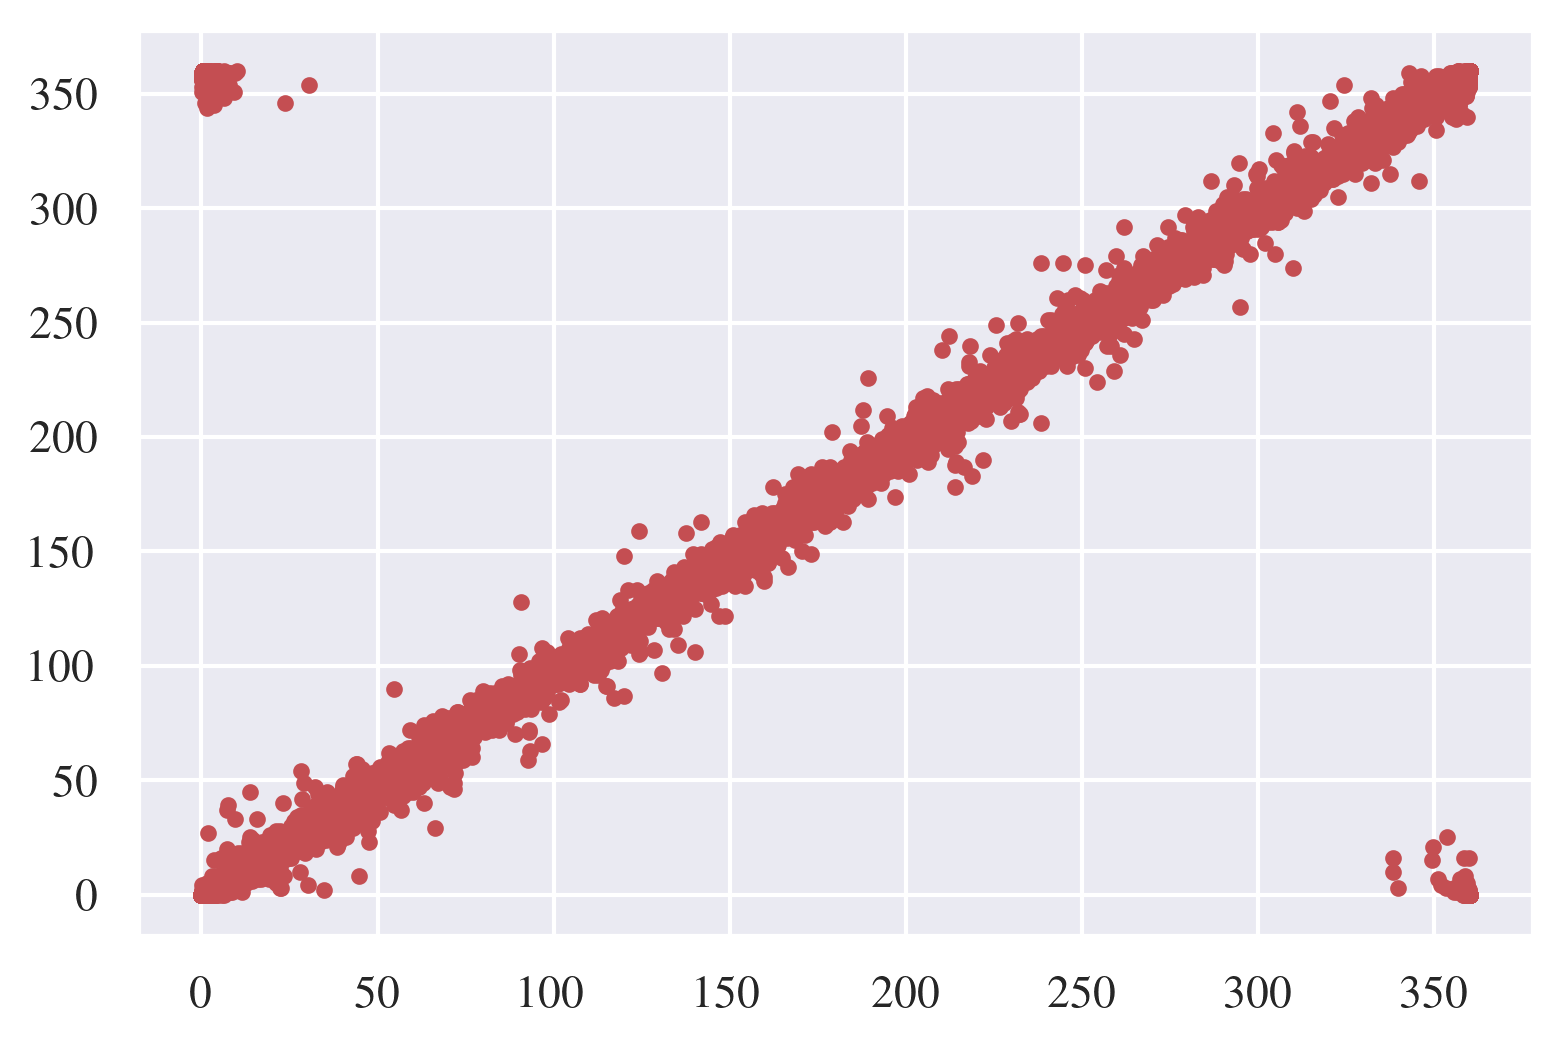

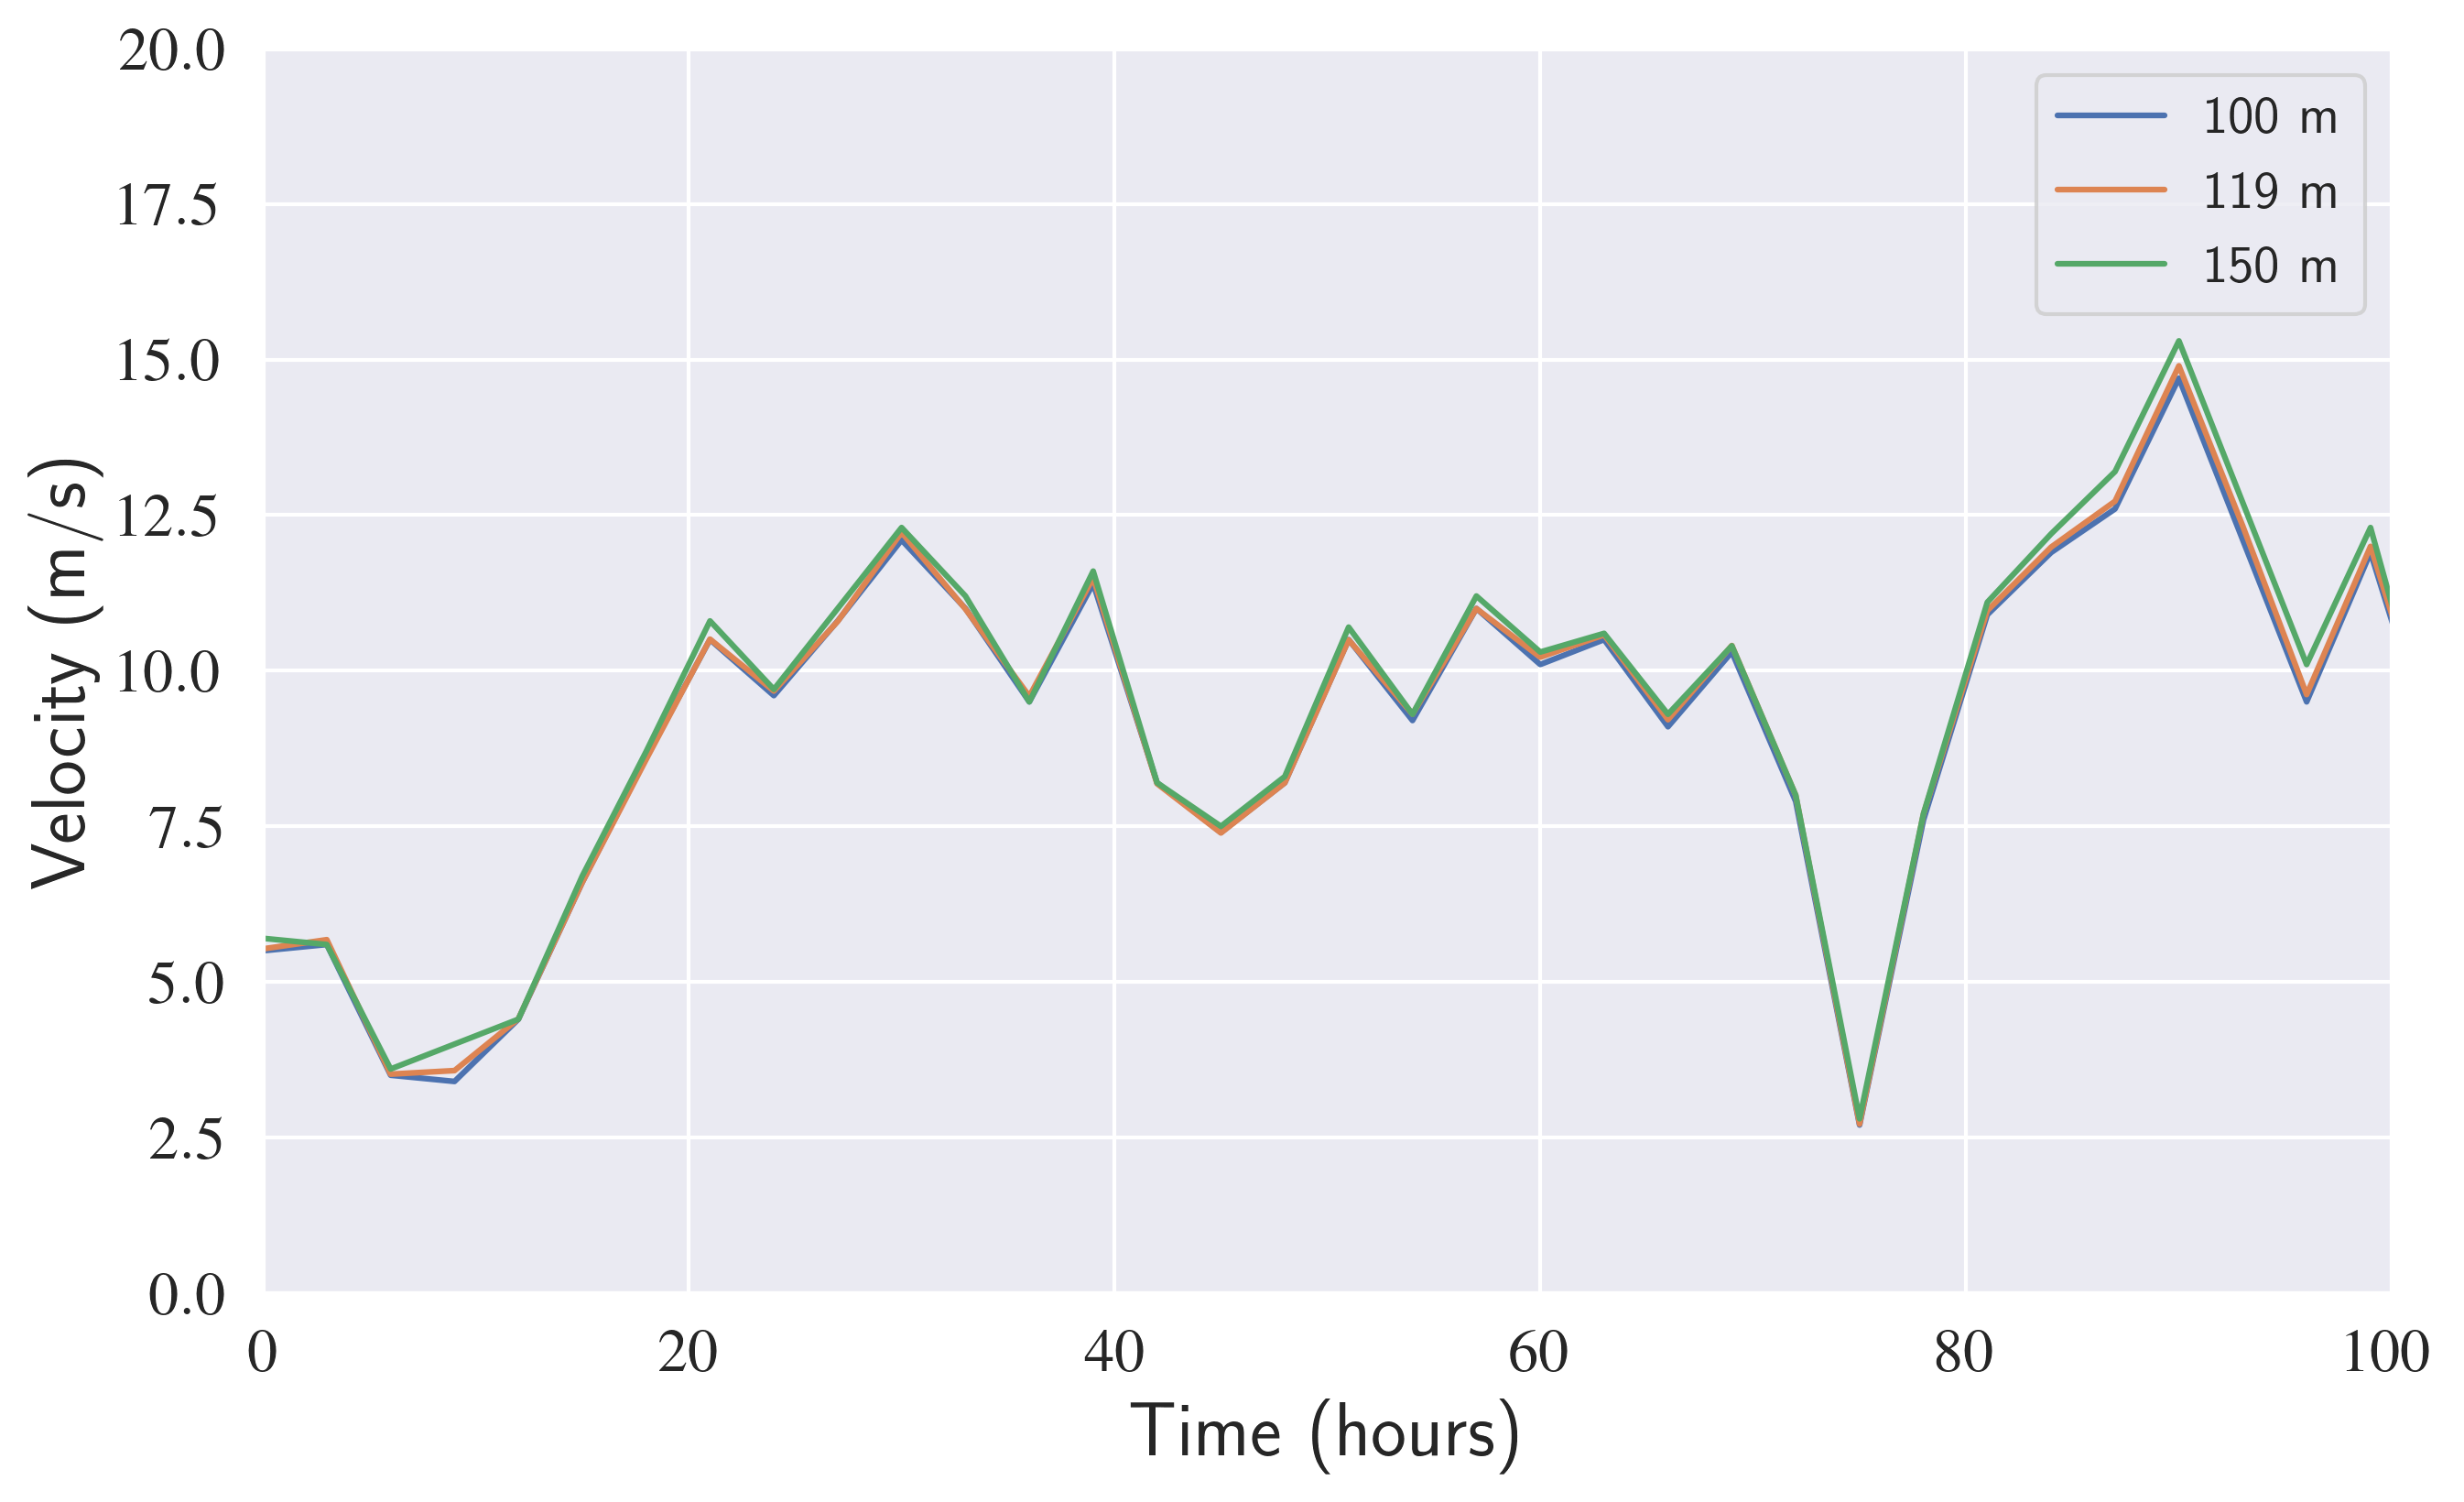

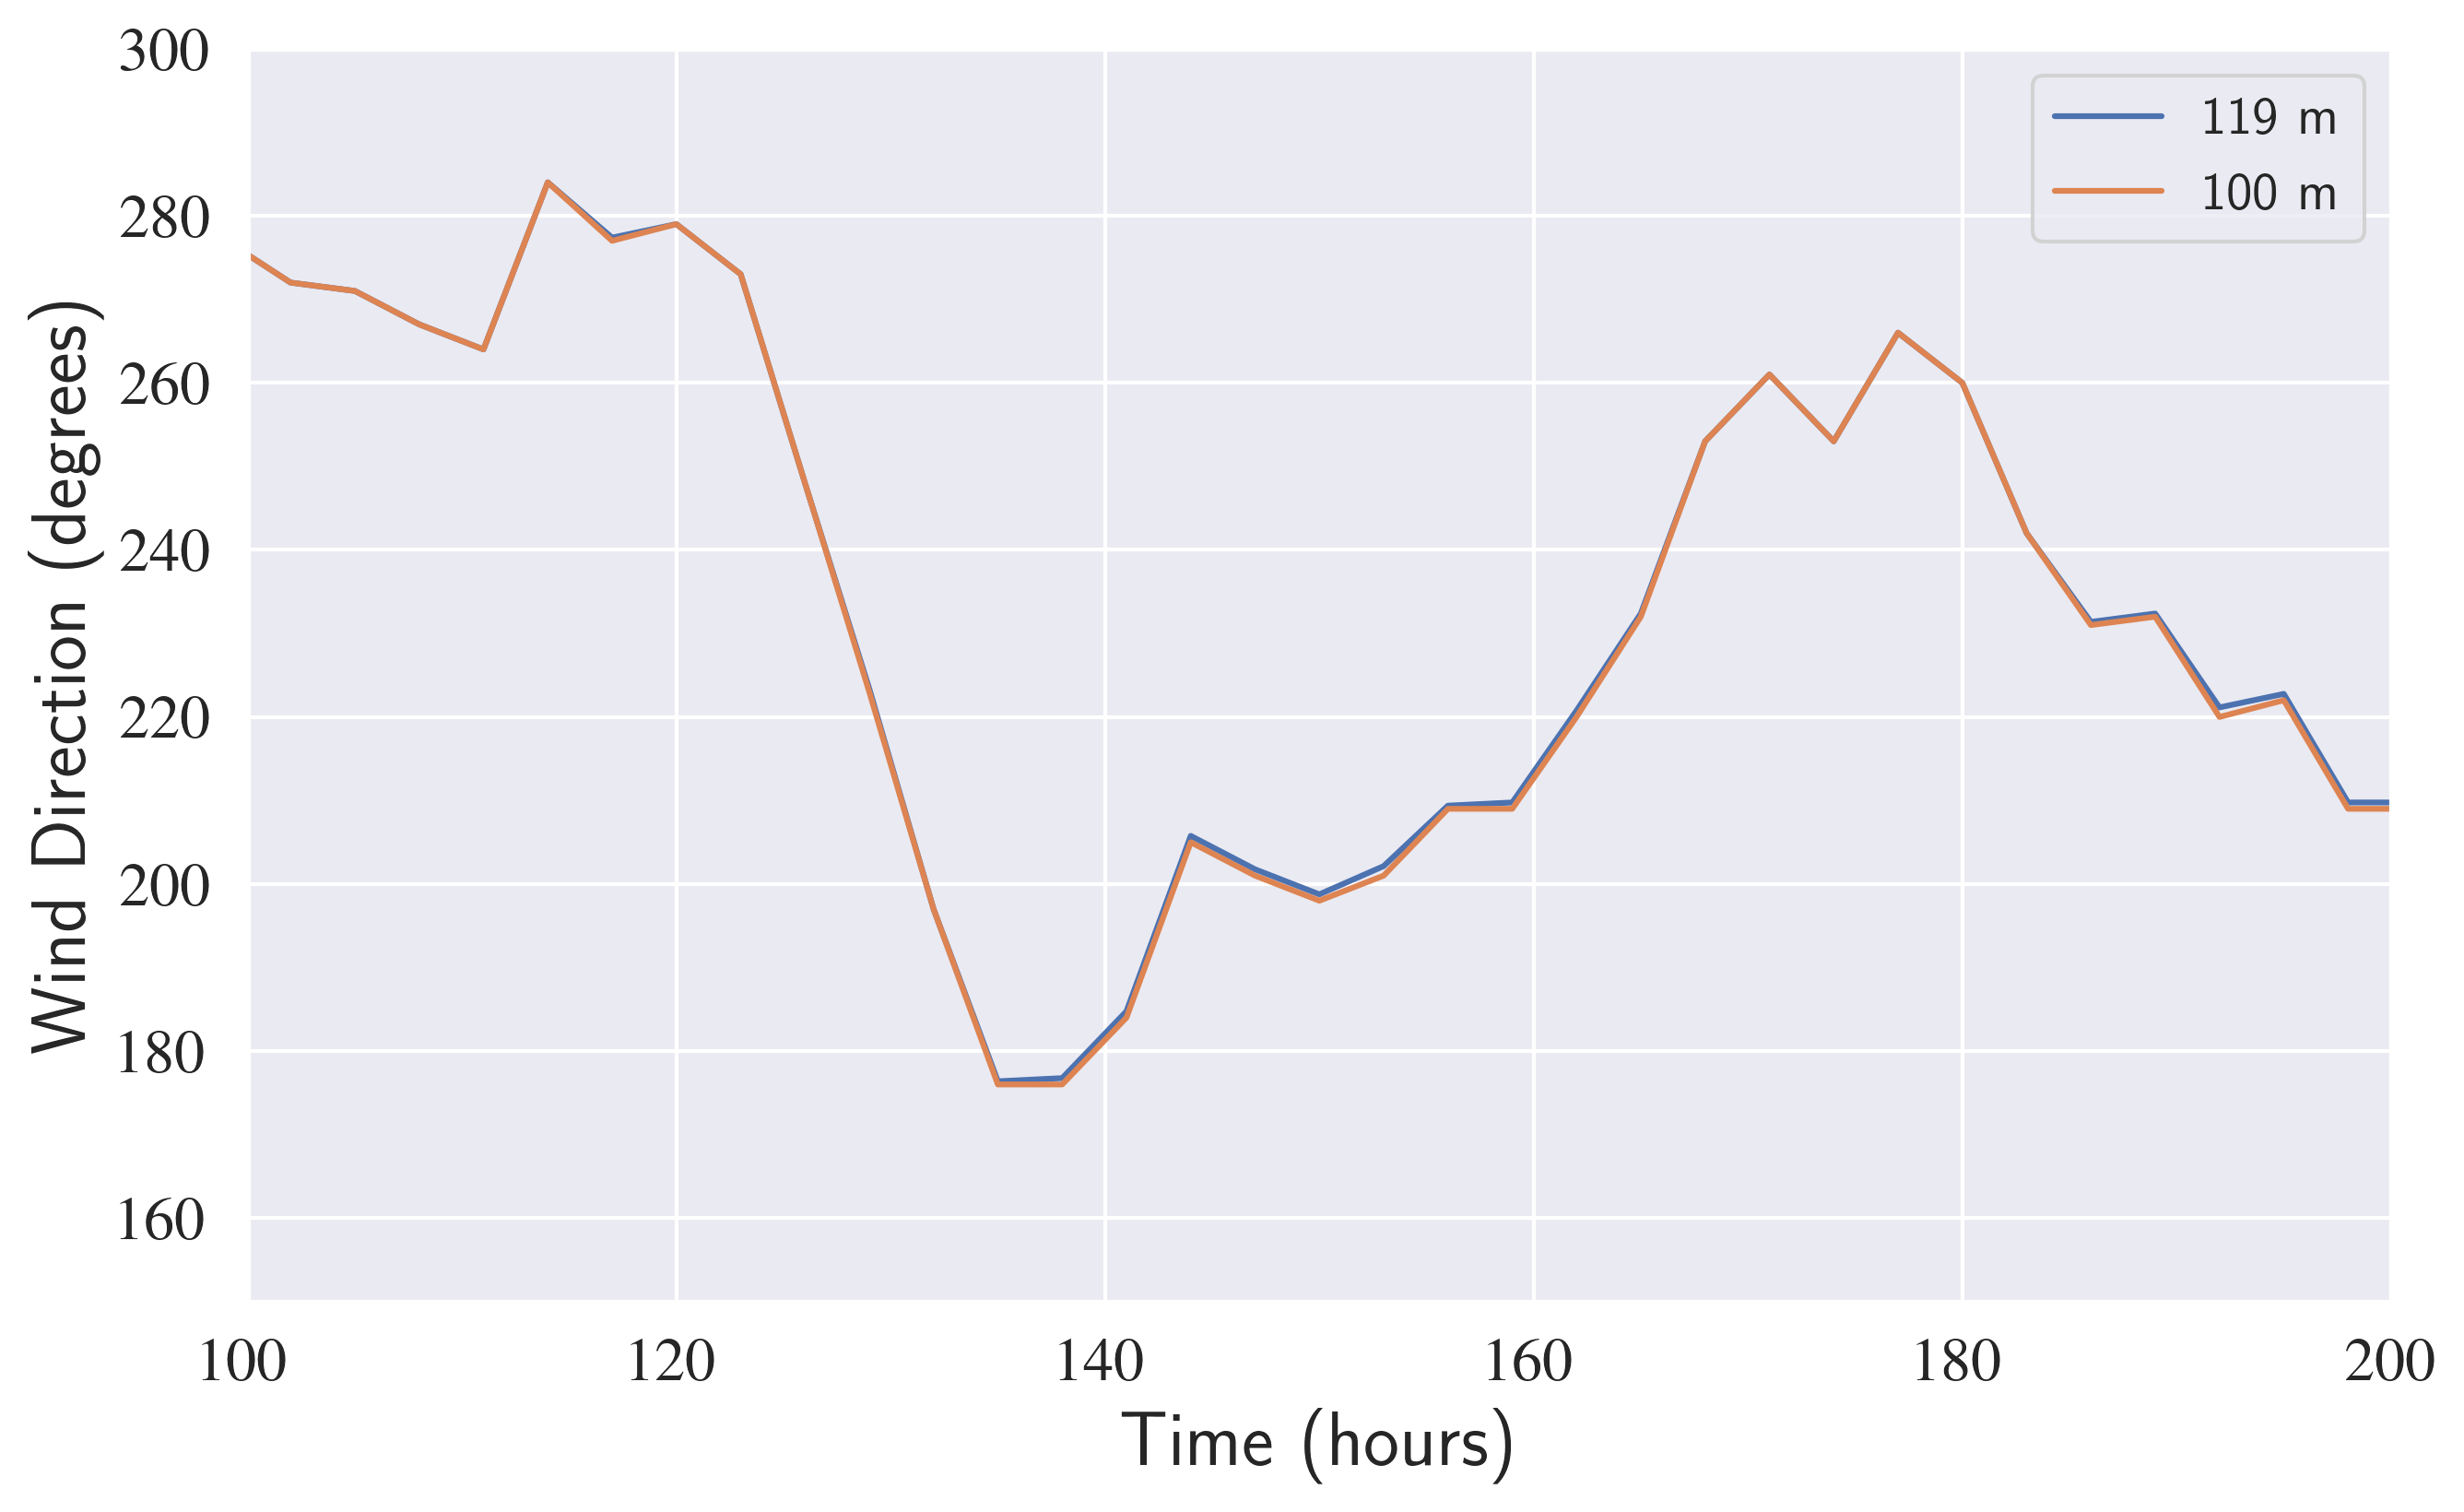

In [4]:
# %% Question 2 
# Generate the interpolator object f
f = RectBivariateSpline(t,oldZ,oldU)
# Interpolate on the new vector Z
newU = f(t,newZ);
newU[newU<0] = 0

# For the wind direction, spliot into 2 components Vx and Vy
oldVx = np.cos(oldDir*np.pi/180) 
oldVy = np.sin(oldDir*np.pi/180)

f = RectBivariateSpline(t,oldZ_dir,oldVx,ky=1)
newVx = f(t,newZ);

f = RectBivariateSpline(t,oldZ_dir,oldVy,ky=1)
newVy = f(t,newZ);


newDir = np.arctan2(newVy,newVx)*180/np.pi
newDir[newDir<0] = newDir[newDir<0]  + 360
 
plt.plot(newDir[:,indZ],oldDir.iloc[:,1],'r.')
plt.savefig('figures/wind_direction_2_components.pdf')

# Plot the time series at Hub height to check that the interpolation is OK

# Plot Wind Speeds
fig, axs_speed = plt.subplots(figsize=(10, 6))
axs_speed.plot(t, newU[:, [indZ - 1, indZ, indZ + 1]])
axs_speed.set_xlim(0, 100)
axs_speed.set_ylim(0, 20)
axs_speed.set_ylabel('Velocity (m/s)', fontsize=20)
axs_speed.legend(['100 m', '119 m', '150 m'], fontsize=14)
axs_speed.set_xlabel('Time (hours)', fontsize=20)
axs_speed.tick_params(axis='both', labelsize=16)

# Save Wind Speeds Plot
plt.savefig('figures/time_series_hubheight.pdf')

# Plot Wind Directions
fig, axs_direction = plt.subplots(figsize=(10, 6))
axs_direction.plot(t, newDir[:, indZ])
axs_direction.plot(t, oldDir.iloc[:, 1])
axs_direction.set_xlim(100, 200)
axs_direction.set_ylim(150, 300)
axs_direction.set_xlabel('Time (hours)', fontsize=20)
axs_direction.set_ylabel('Wind Direction (degrees)', fontsize=20)
axs_direction.legend(['119 m', '100 m'], fontsize=14)
axs_direction.tick_params(axis='both', labelsize=16)

# Save Wind Directions Plot
plt.savefig('figures/wind_direction_plot.pdf')

## Question 3

a =  2.3  and b =  12.0 


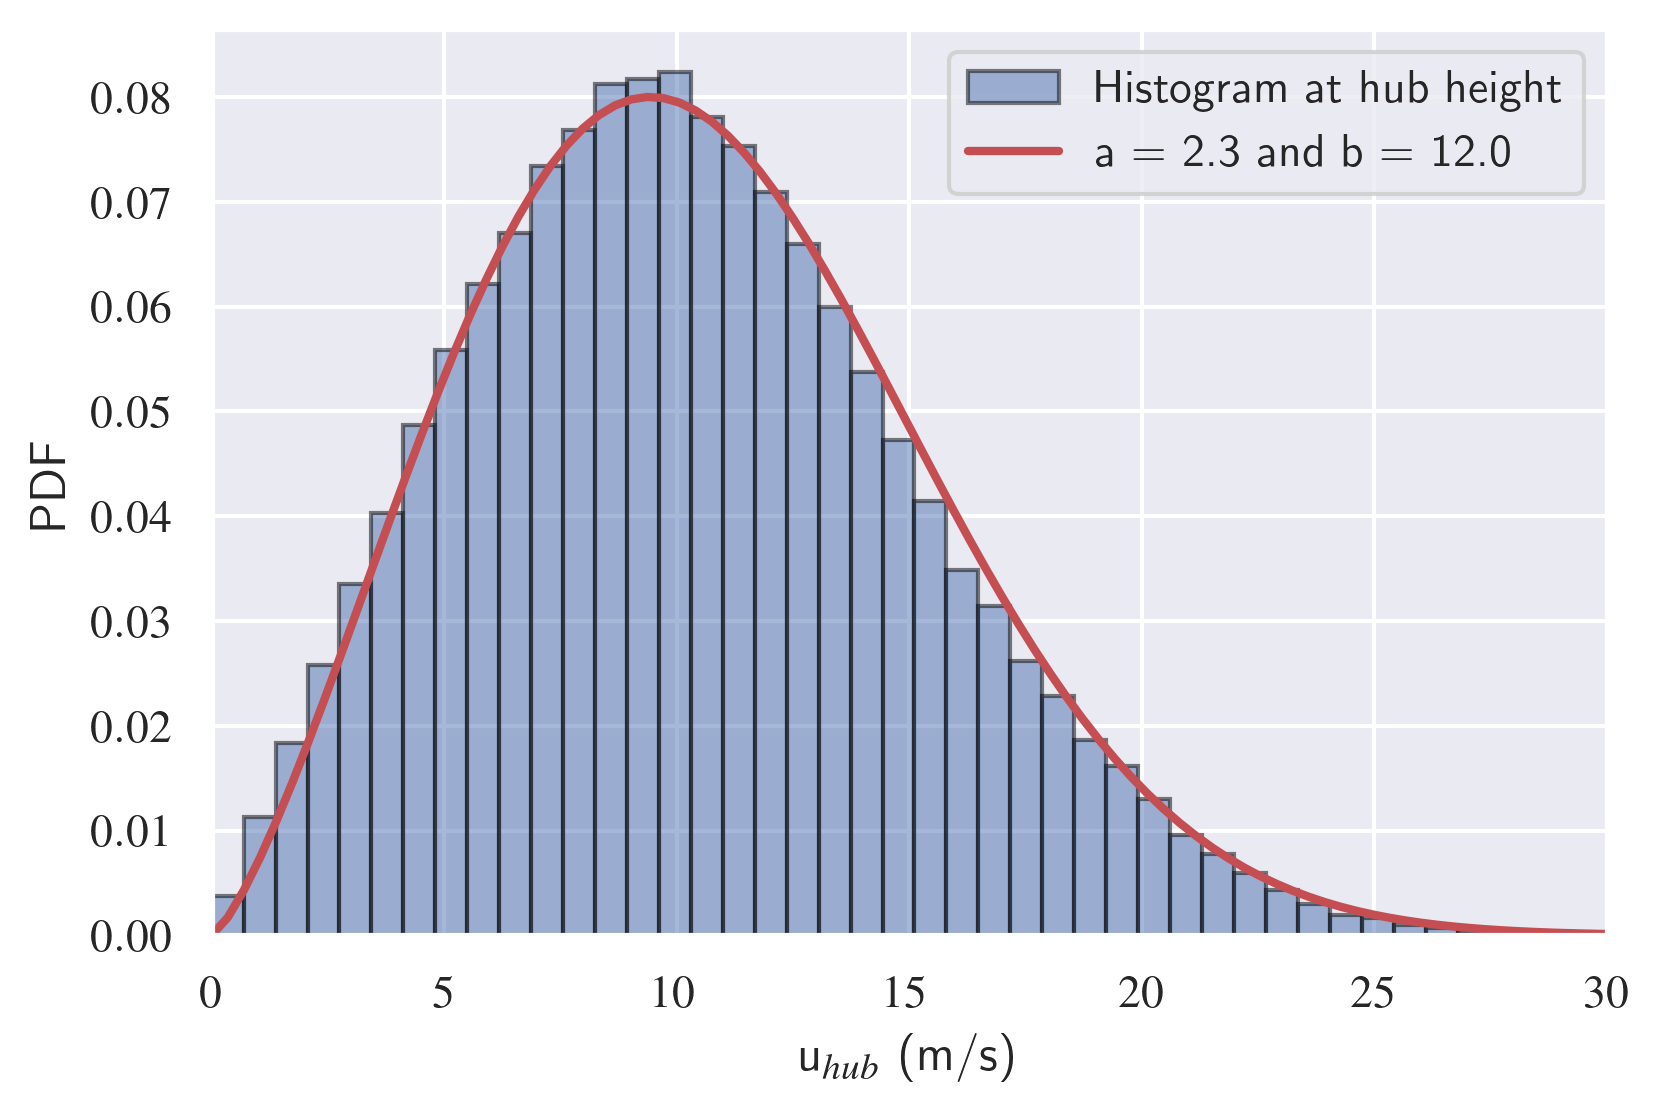

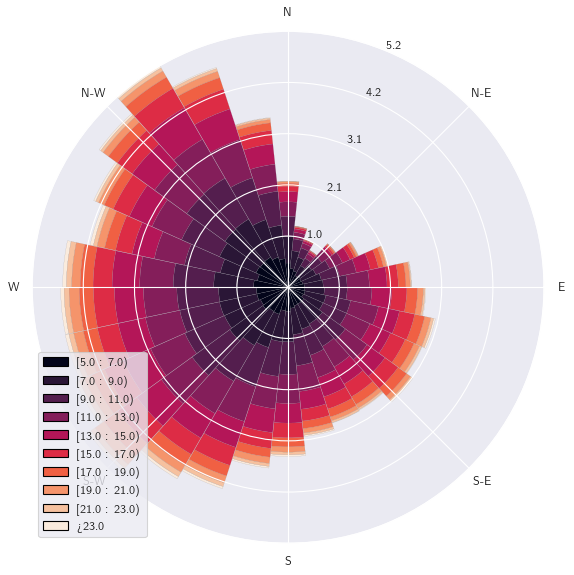

In [5]:
# %% Question 3
#  Distribution of mean wind speed
# For with the 2-para Weibull distribution
from scipy.stats import weibull_min

params = stats.exponweib.fit(newU[:,indZ], loc=0, f0=1)
a = params[1]
b = params[3]
u = np.linspace(np.min(newU[:,indZ]),np.max(newU[:,indZ]),100)
myPDF = weibull_min.pdf(u, a,scale = b)
print("a =  {:.1f}  and b =  {:.1f} ".format(a,b))

# Plot the pdf for all sector

mylabel="a =  {:.1f}  and b =  {:.1f} ".format(a,b)

fig = plt.figure()
plt.hist(newU[:,indZ], bins=50,label = 'Histogram at hub height',
         density=True, alpha=0.5,edgecolor='black')
plt.plot(u, myPDF, linewidth=2, label = mylabel ,color='r')
plt.xlim([0,30]) 
plt.legend()
plt.xlabel("u$_{hub}$ (m/s)", usetex=True)
plt.ylabel("PDF")

plt.savefig('figures/hist_wind_speeds.pdf')

# Wind rose

from windrose import WindroseAxes
ax = WindroseAxes.from_ax()
dummyU = newU[:,indZ];
D = newDir[:,indZ]
D = D[dummyU>5]
dummyU = dummyU[dummyU>5]

ax.bar(D,dummyU, nsector= 30,opening=0.99, 
       bins=np.arange(5, 25, 2),edgecolor='gray',lw=0.1, normed=True)
ax.set_theta_zero_location('W', offset=-180)
plt.legend()

plt.savefig('figures/wind_rose.pdf')

## Question 4

a =  2.2  and b =  10.9 
a =  2.5  and b =  12.7 
a =  2.5  and b =  12.5 
a =  2.3  and b =  12.1 


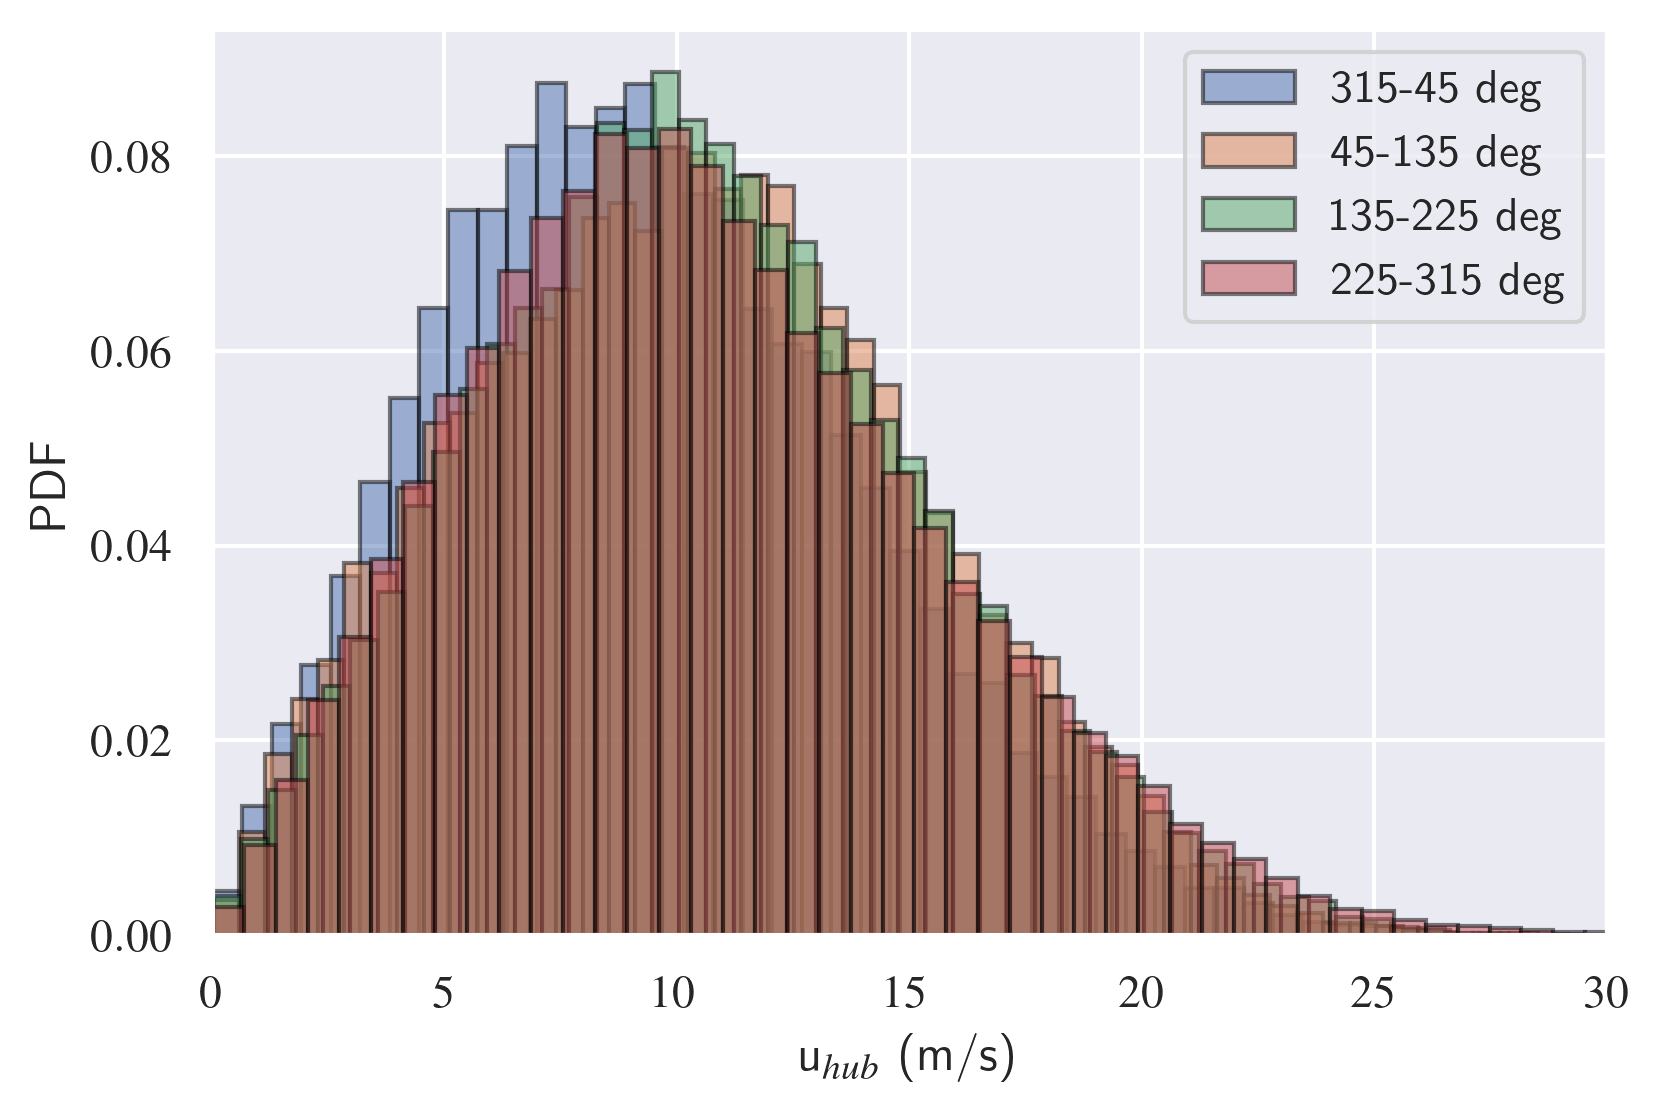

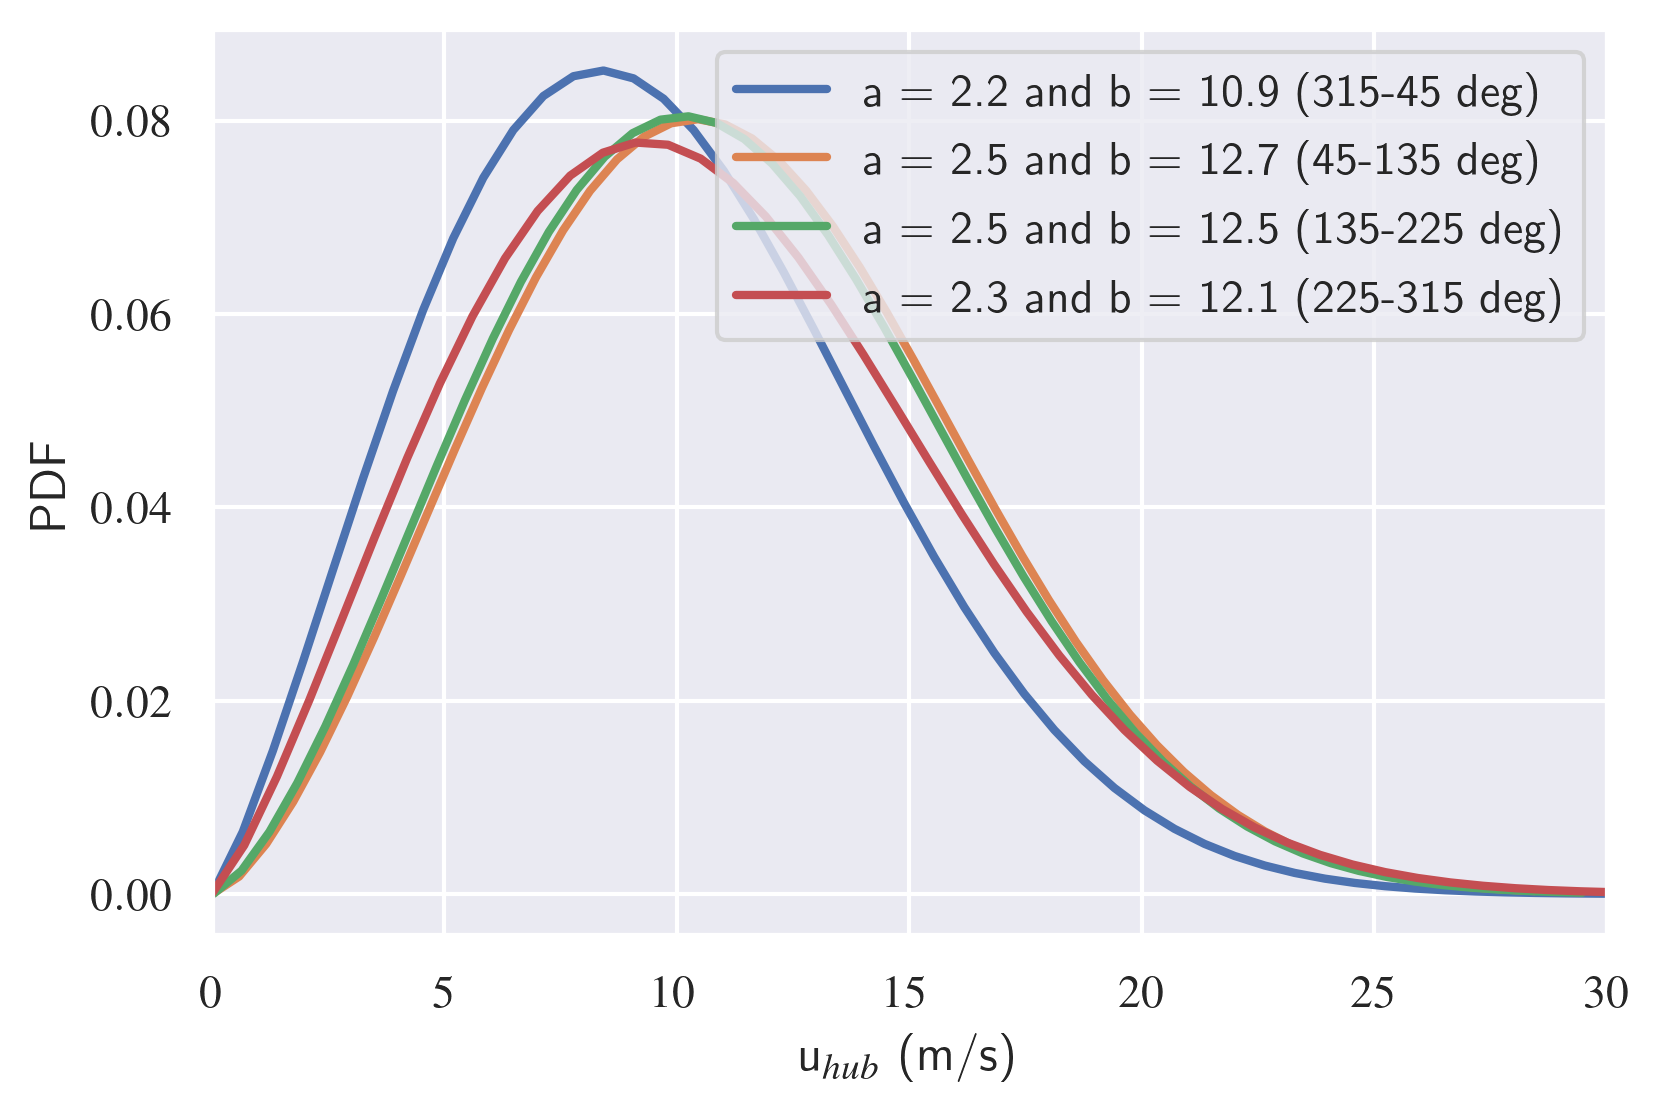

In [6]:
# %% Question 4
# Weibull fir for the four sectors requested

d = newDir[:,indZ]
indDir=   (tuple(np.where((d>315) | (d<45))),
           tuple(np.where((d>45) & (d<135))),
           tuple(np.where((d>135) & (d<225))),
           tuple( np.where((d>225) & (d<315))))
myLabel1 = ('315-45 deg','45-135 deg', '135-225 deg','225-315 deg')



fig = plt.figure()
for ii in range(len(indDir)):
    u = newU[indDir[ii],indZ]
    u=u.transpose()
    plt.hist(u, bins=50,label = myLabel1[ii],
         density=True, alpha=0.5,edgecolor='black')

plt.xlim([0,30]) 
plt.legend()
plt.xlabel("u$_{hub}$ (m/s)", usetex=True)
plt.ylabel("PDF")
plt.savefig("figures/weibull_sectors_1.pdf")


fig = plt.figure()
for ii in range(len(indDir)):
    u = newU[indDir[ii],indZ]
    u=u.transpose()
    params = stats.exponweib.fit(u, loc=0, f0=1)
    a = params[1]
    b = params[3]
    u_pdf = np.linspace(np.min(u),np.max(u),50)
    myPDF = weibull_min.pdf(u_pdf, a,scale = b)
    print("a =  {:.1f}  and b =  {:.1f} ".format(a,b))
    mylabel2="a =  {:.1f}  and b =  {:.1f} ".format(a,b)
    plt.plot(u_pdf, myPDF, linewidth=2, label = mylabel2 + ' (' + myLabel1[ii] + ')' )
    
plt.xlim([0,30]) 
plt.legend()
plt.xlabel("u$_{hub}$ (m/s)", usetex=True)
plt.ylabel("PDF")
plt.savefig("figures/weibull_sectors_2.pdf")

# Only the Northern-northeastern sector display significant difference


## Question 5: Approach 1 for yearly trend

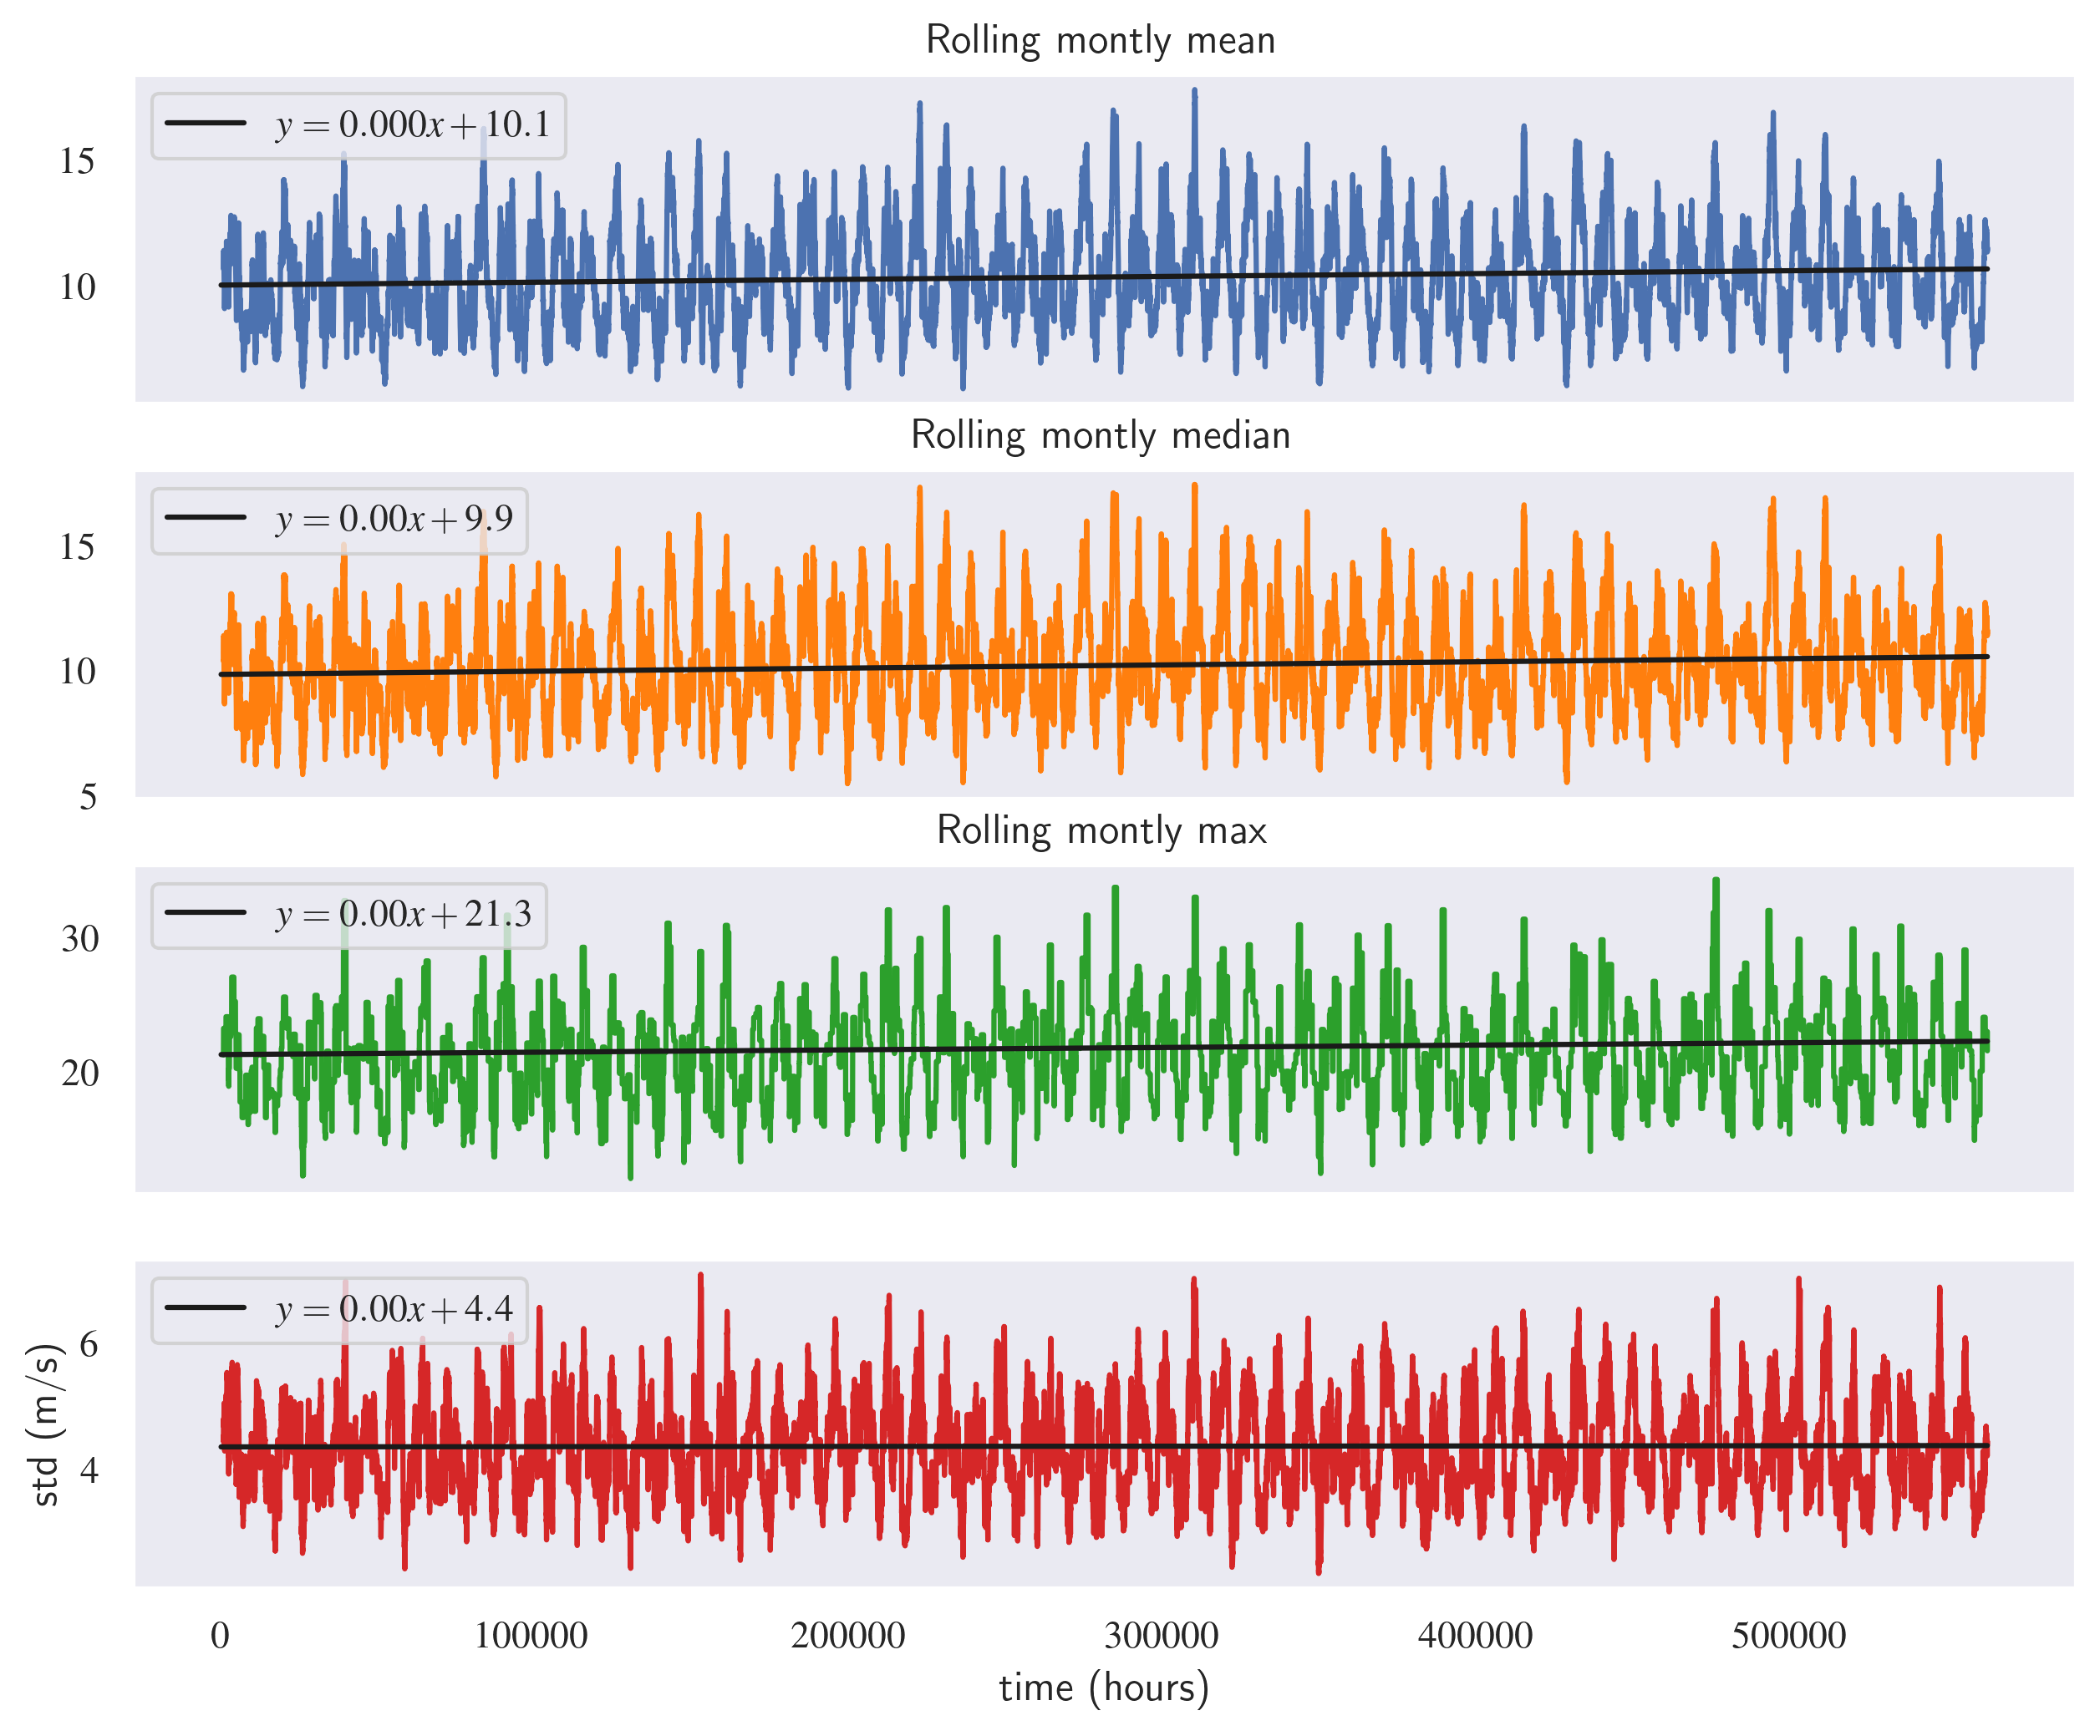

In [7]:
# %% Question 5: approach 1 for yearly trend


movMean =   pd.Series(newU[:,indZ]).rolling(int(np.round(720/dt))).mean()
movMedian = pd.Series(newU[:,indZ]).rolling(int(np.round(720/dt))).median()
movMax = pd.Series(newU[:,indZ]).rolling(int(np.round(720/dt))).max()
movStd = pd.Series(newU[:,indZ]).rolling(int(np.round(720/dt))).std()

fig, axs = plt.subplots(4, 1,figsize=(10, 8), sharex=True)
axs[0].plot(t,movMean)
m, b = np.polyfit(t[~np.isnan(movMean)],movMean[~np.isnan(movMean)], deg=1)
myFun = np.poly1d(np.array([m,b])) 
axs[0].plot(t[[0,-1]],myFun(t[[0,-1]]),color='k', label=f'$y = {m:.3f}x {b:+.1f}$')
axs[0].legend()
axs[0].set_title('Rolling montly mean')
axs[0].grid()


axs[1].plot(t,movMedian, 'tab:orange')
axs[1].set_title('Rolling montly median')
m, b = np.polyfit(t[~np.isnan(movMedian)],movMedian[~np.isnan(movMedian)], deg=1)
myFun = np.poly1d(np.array([m,b])) 
axs[1].plot(t[[0,-1]],myFun(t[[0,-1]]),color='k', label=f'$y = {m:.2f}x {b:+.1f}$')
axs[1].legend()
axs[1].grid()

axs[2].plot(t,movMax, 'tab:green')
axs[2].set_title('Rolling montly max')
m, b = np.polyfit(t[~np.isnan(movMax)],movMax[~np.isnan(movMax)], deg=1)
myFun = np.poly1d(np.array([m,b])) 
axs[2].plot(t[[0,-1]],myFun(t[[0,-1]]),color='k', label=f'$y = {m:.2f}x {b:+.1f}$')
axs[2].legend()
axs[2].grid()

axs[3].plot(t,movStd, 'tab:red')
axs[3].set_title('')
m, b = np.polyfit(t[~np.isnan(movStd)],movStd[~np.isnan(movStd)], deg=1)
myFun = np.poly1d(np.array([m,b])) 
axs[3].plot(t[[0,-1]],myFun(t[[0,-1]]),color='k', label=f'$y = {m:.2f}x {b:+.1f}$')
axs[3].legend()
axs[3].set(xlabel='time (hours)', ylabel='std (m/s)')
axs[3].grid()
plt.savefig('figures/question_5_approach_1.pdf')

# No trend visible over the period selected

## Question 5: Approach 2 for yearly trend

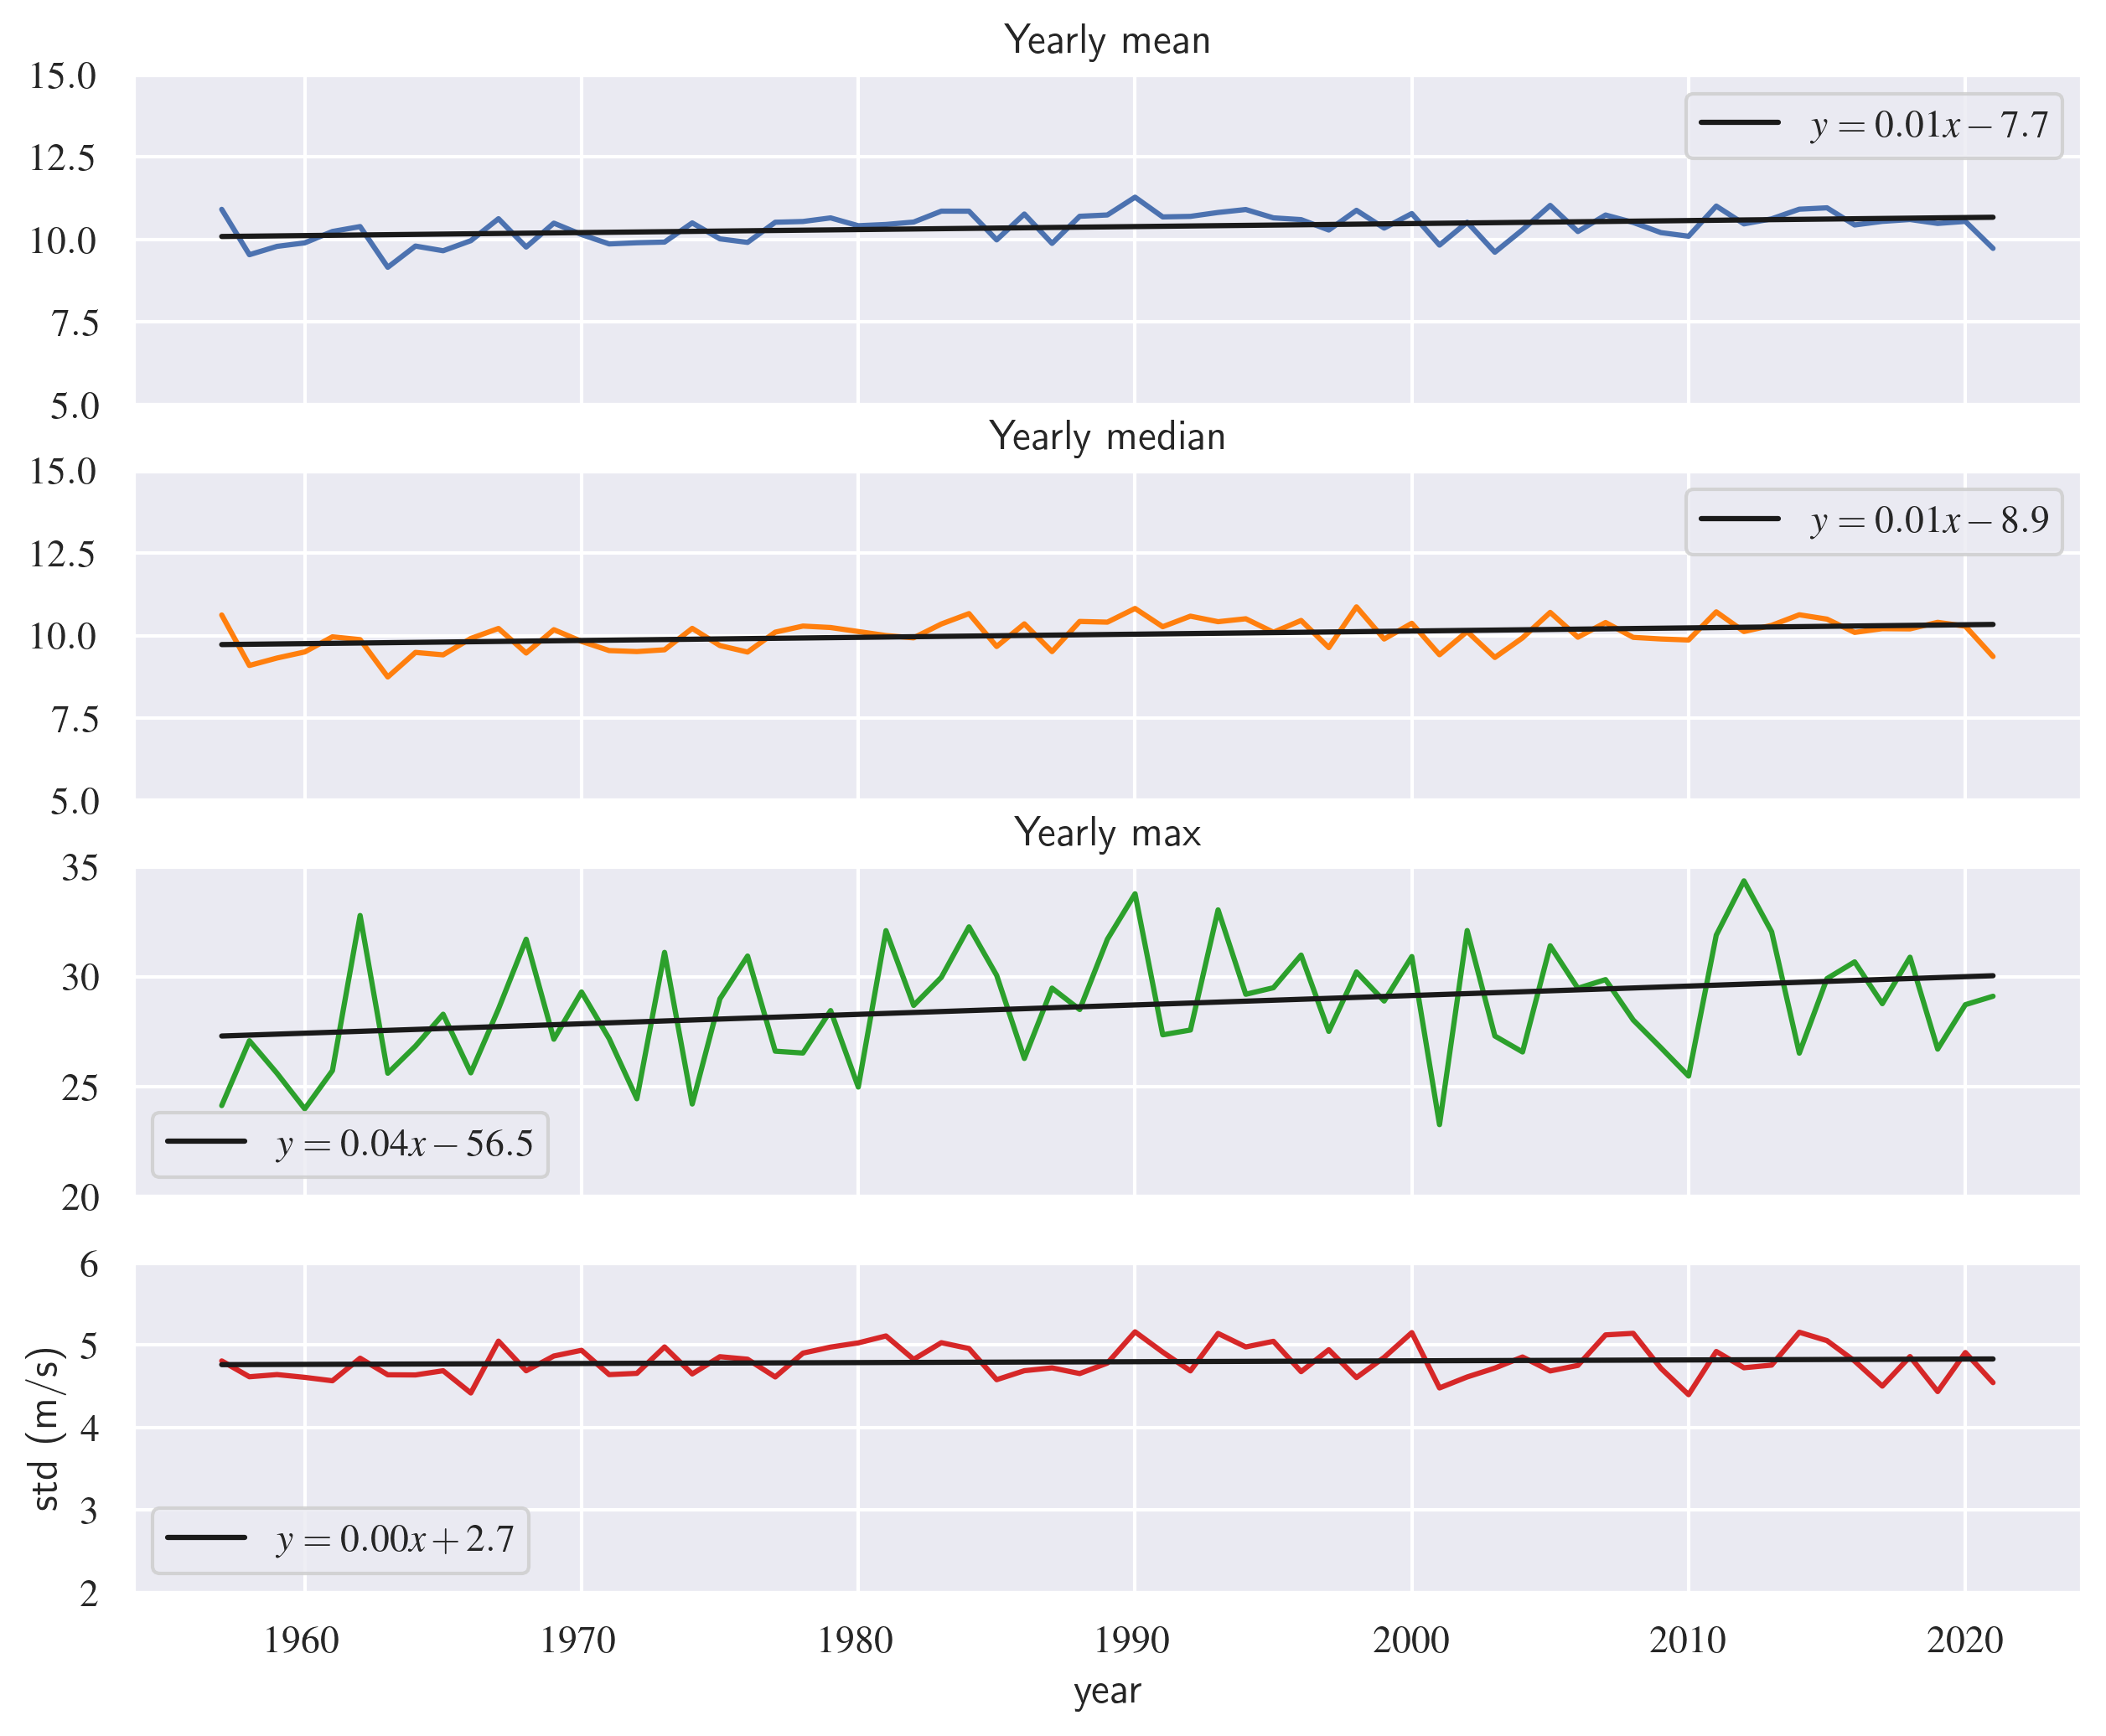

In [8]:
# %% Question 5: approach 2 for yearly trend

tYear0 = np.array([pd.DatetimeIndex(time).year])
tYear = np.unique(tYear0)
Nyear =  tYear.size

movMean = np.zeros([Nyear])*np.nan
movMedian = np.zeros([Nyear])*np.nan
movMax = np.zeros([Nyear])*np.nan
movStd = np.zeros([Nyear])*np.nan

for ii in range(0,Nyear):
    
    indYear=np.where(tYear0==tYear[ii])
    indYear = indYear[1]
    movMean[ii] = np.mean(newU[indYear,indZ])
    movMedian[ii] = np.median(newU[indYear,indZ])
    movMax[ii] = np.max(newU[indYear,indZ])
    movStd[ii] = np.std(newU[indYear,indZ])
    

fig, axs = plt.subplots(4, 1,figsize=(10, 8), sharex=True)
axs[0].plot(tYear,movMean)
m, b = np.polyfit(tYear[~np.isnan(movMean)],movMean[~np.isnan(movMean)], deg=1)
myFun = np.poly1d(np.array([m,b])) 
axs[0].plot(tYear[[0,-1]],myFun(tYear[[0,-1]]),color='k', label=f'$y = {m:.2f}x {b:+.1f}$')
axs[0].legend()
axs[0].set_title('Yearly mean')
axs[0].set_ylim([5, 15])
axs[1].plot(tYear,movMedian, 'tab:orange')
axs[1].set_title('Yearly median')
m, b = np.polyfit(tYear[~np.isnan(movMedian)],movMedian[~np.isnan(movMedian)], deg=1)
myFun = np.poly1d(np.array([m,b])) 
axs[1].plot(tYear[[0,-1]],myFun(tYear[[0,-1]]),color='k', label=f'$y = {m:.2f}x {b:+.1f}$')
axs[1].legend()
axs[1].set_ylim([5, 15])

axs[2].plot(tYear,movMax, 'tab:green')
axs[2].set_title('Yearly max')
m, b = np.polyfit(tYear[~np.isnan(movMax)],movMax[~np.isnan(movMax)], deg=1)
myFun = np.poly1d(np.array([m,b])) 
axs[2].plot(tYear[[0,-1]],myFun(tYear[[0,-1]]),color='k', label=f'$y = {m:.2f}x {b:+.1f}$')
axs[2].legend()
axs[2].set_ylim([20, 35])

axs[3].set_title('Yearly std')
axs[3].plot(tYear,movStd, 'tab:red')
axs[3].set_title('')
m, b = np.polyfit(tYear[~np.isnan(movStd)],movStd[~np.isnan(movStd)], deg=1)
myFun = np.poly1d(np.array([m,b])) 
axs[3].plot(tYear[[0,-1]],myFun(tYear[[0,-1]]),color='k', label=f'$y = {m:.2f}x {b:+.1f}$')
axs[3].legend()
axs[3].set(xlabel='year', ylabel='std (m/s)')
axs[3].set_ylim([2, 6])

plt.savefig('figures/question_5_approach_2.pdf')

## Question 6:

0
1
2
3
4
5
6
7
8
9
10
11


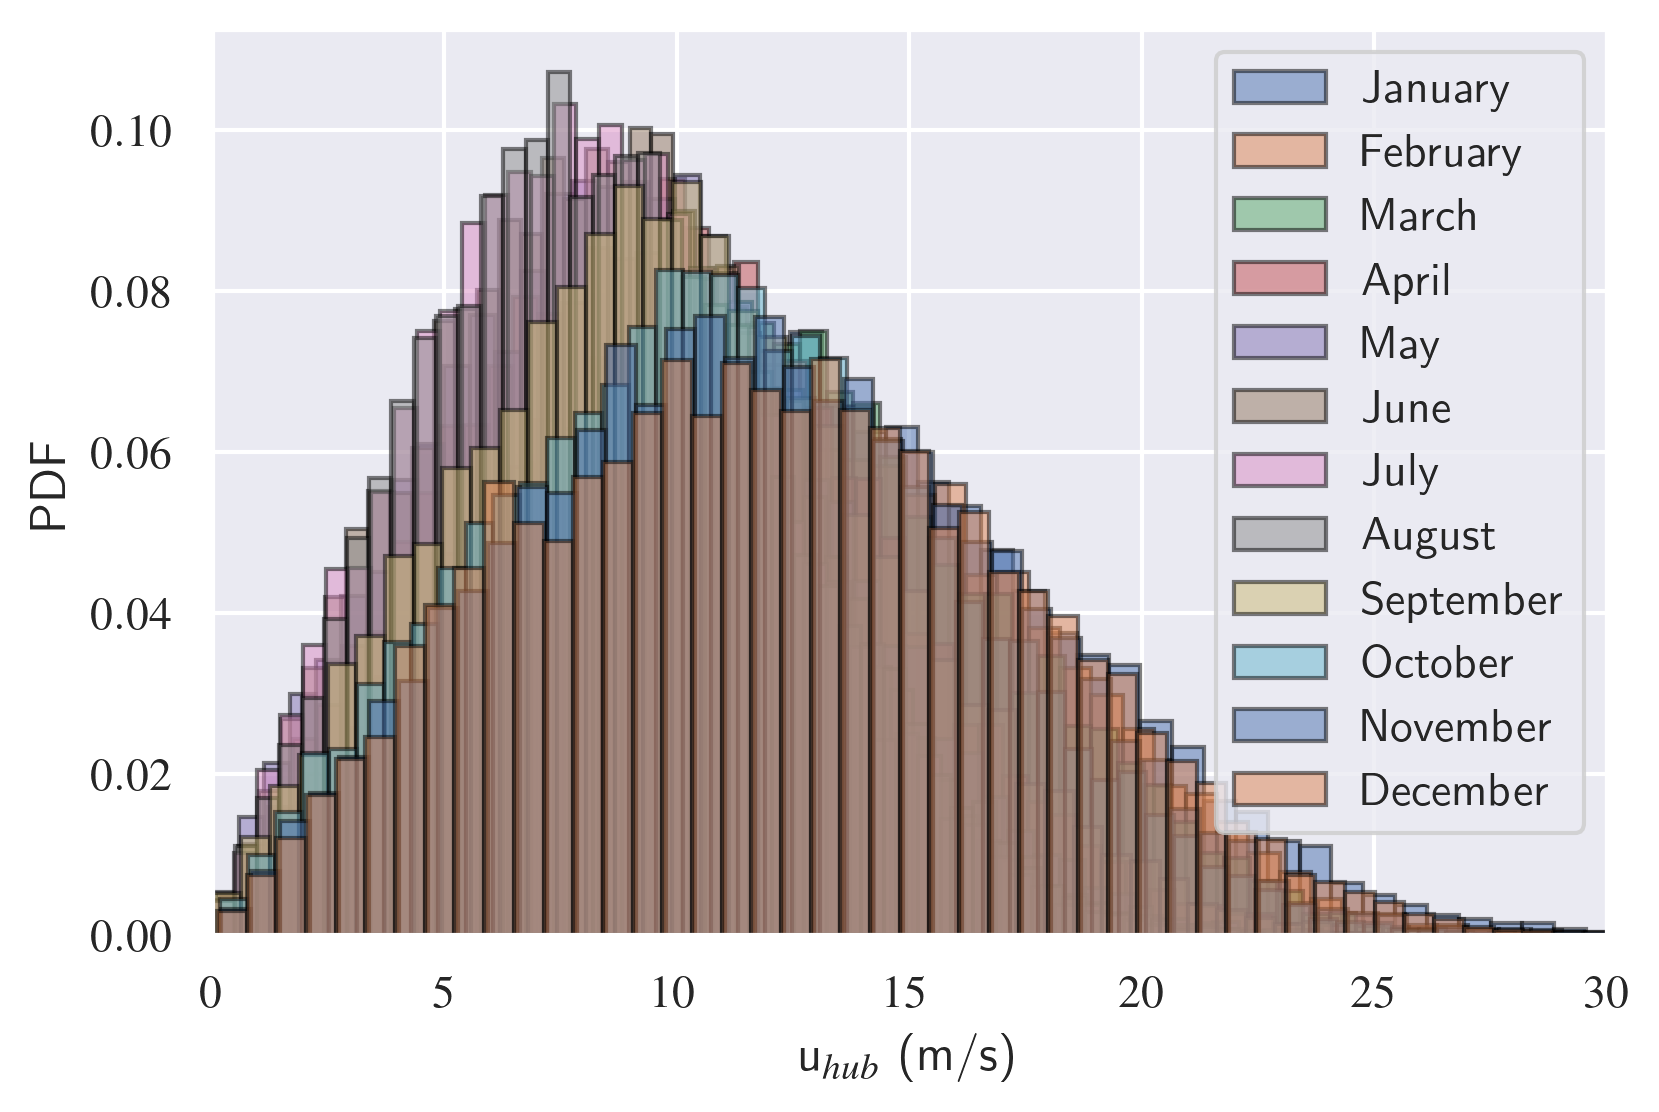

In [9]:
# %% Question 6
import calendar

# histogram for each month

pd_time = pd.DatetimeIndex(time)

fig = plt.figure()
for ii in range(12):
    print(ii)
    ind = np.where(pd_time.month==ii+1)
    u = newU[ind,indZ]
    u=u.transpose()
    myLabel = calendar.month_name[ii+1]
    plt.hist(u, bins=50,label = myLabel,
         density=True, alpha=0.5,edgecolor='black')
plt.xlim([0,30]) 
plt.legend()
plt.xlabel("u$_{hub}$ (m/s)", usetex=True)
plt.ylabel("PDF")

plt.savefig('figures/hist_monthly.pdf')


## Question 7:

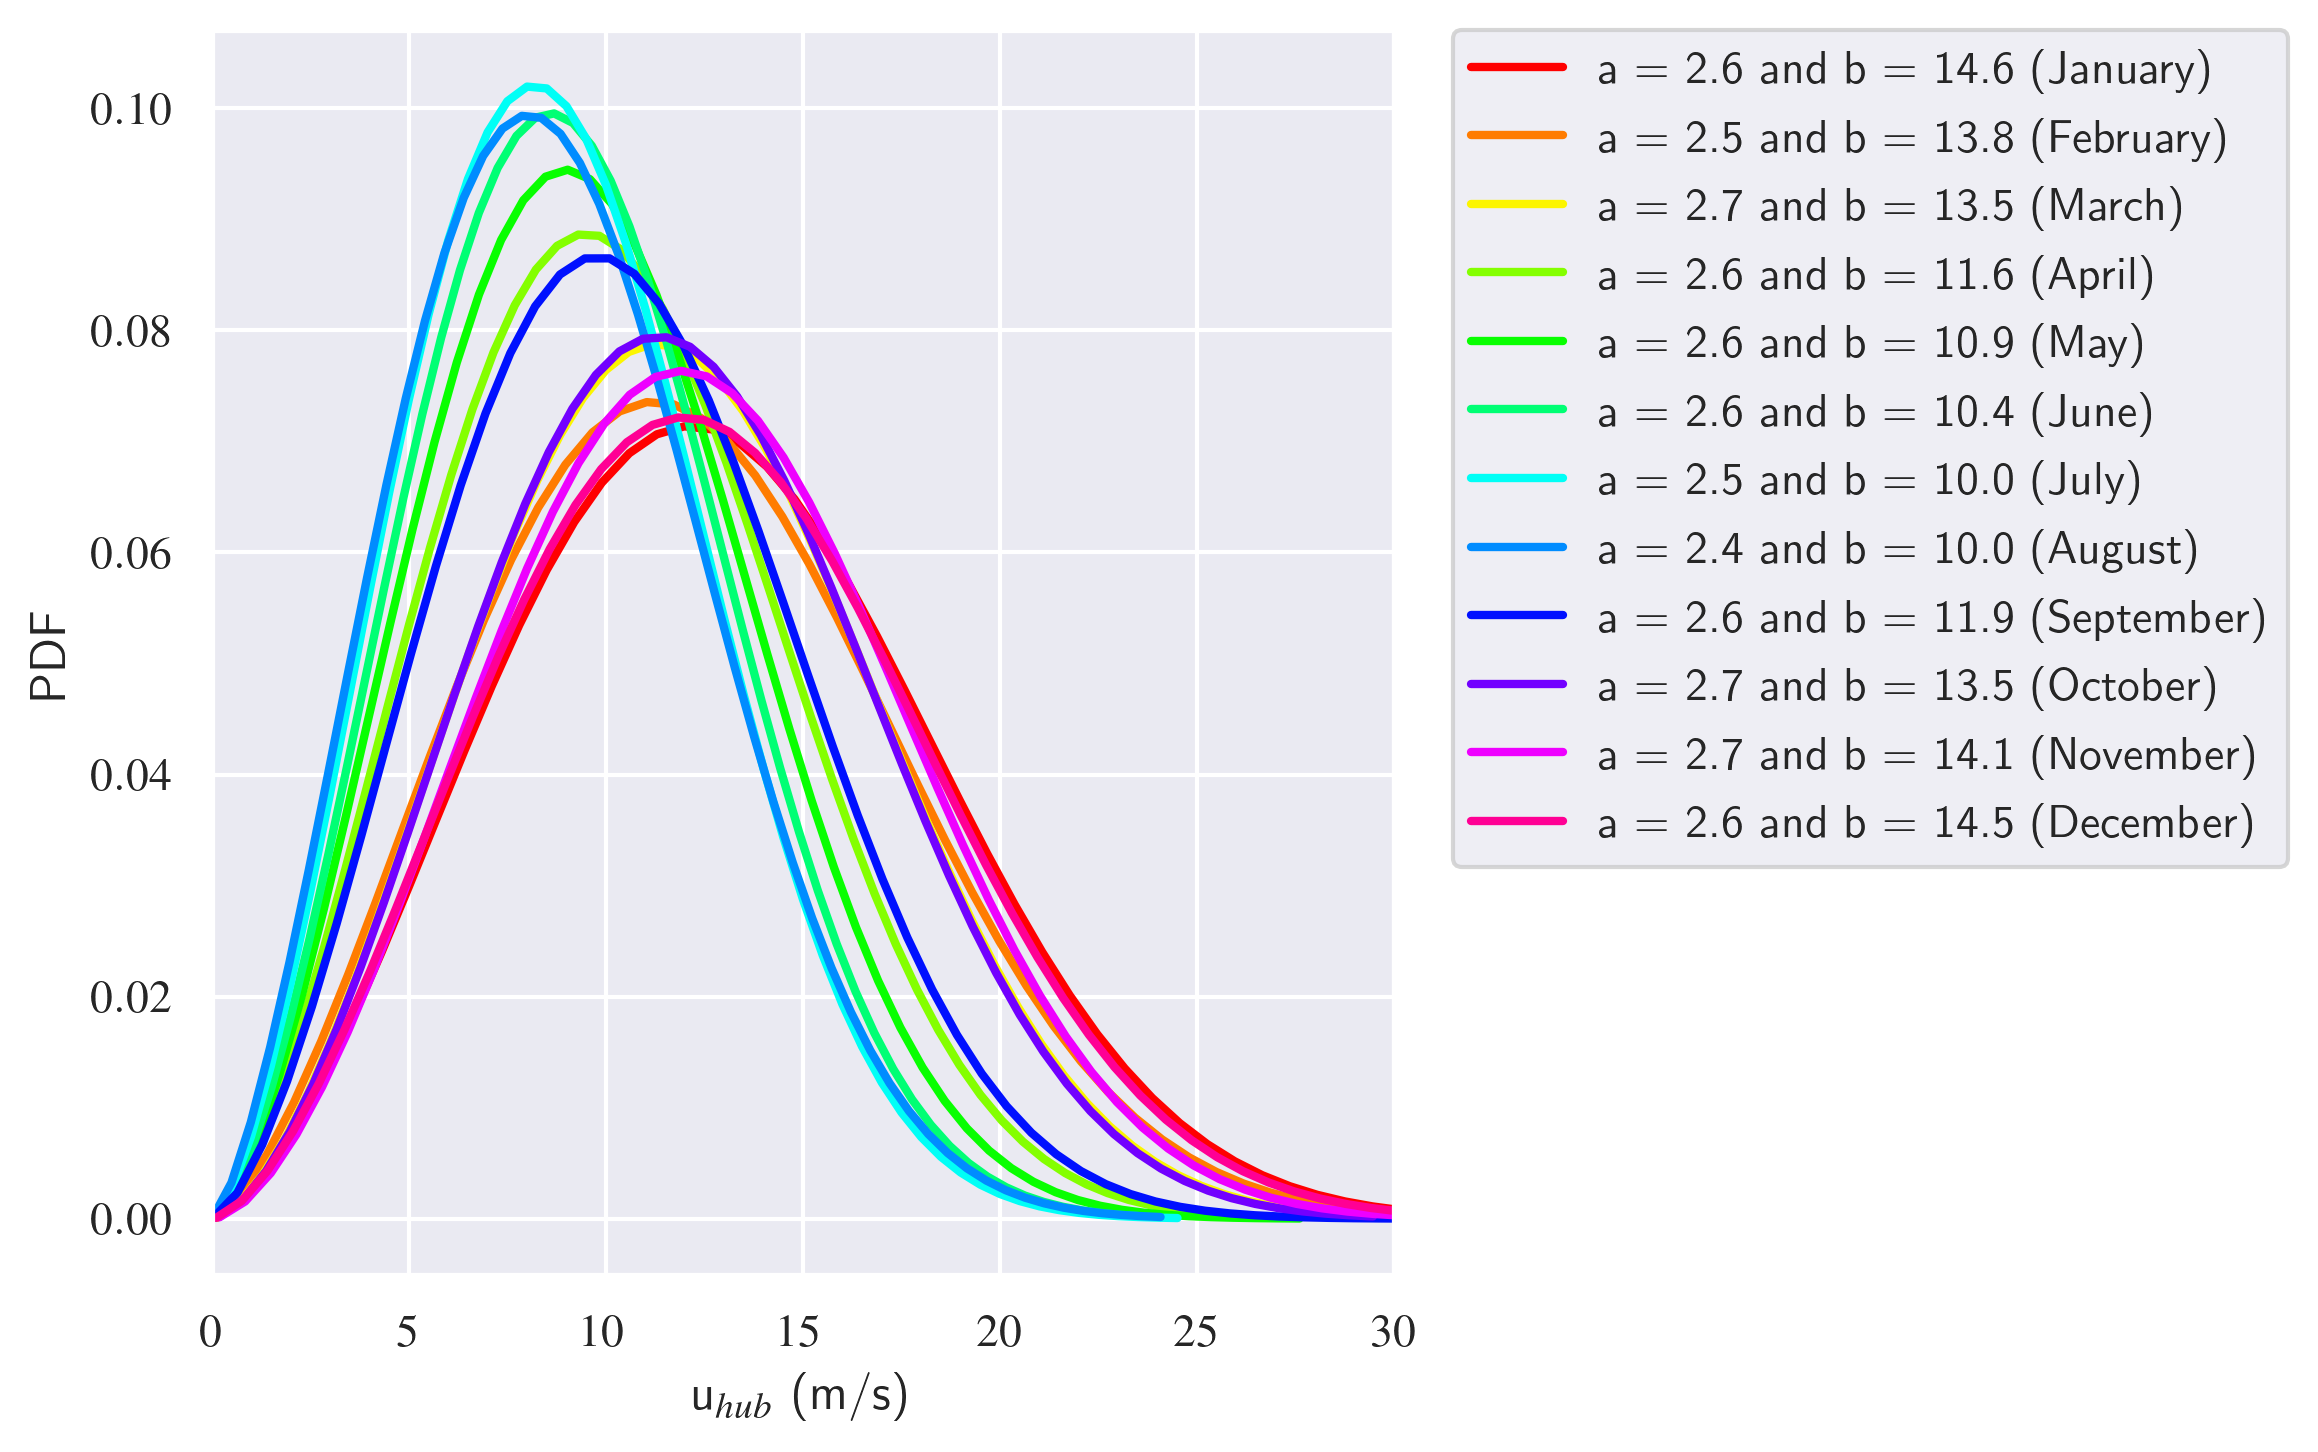

In [10]:
# %% Question 7
import calendar

# histogram for each month
cmap = plt.cm.hsv


pd_time = pd.DatetimeIndex(time)

fig = plt.figure(figsize=(8,5)) # You can adjust the width (first element) as needed
for ii in range(12):
    color = cmap(ii / 12)

    ind = np.where(pd_time.month == ii + 1)
    u = newU[ind, indZ]
    u = u.transpose()
    params = stats.exponweib.fit(u, loc=0, f0=1)
    a = params[1]
    b = params[3]
    u_pdf = np.linspace(np.min(u), np.max(u), 50)
    myPDF = weibull_min.pdf(u_pdf, a, scale=b)
    myLabel1 = calendar.month_name[ii + 1]
    mylabel2 = "a = {:.1f} and b = {:.1f}".format(a, b)
    plt.plot(u_pdf, myPDF, color=color, linewidth=2, label=mylabel2 + ' (' + myLabel1 + ')')
    plt.grid(visible=1)
plt.xlim([0, 30])

# Moving the legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.xlabel("u$_{hub}$ (m/s)", usetex=True)
plt.ylabel("PDF")
plt.tight_layout()  # Adjust the layout to accommodate the legend

plt.savefig('figures/weibull_monthly.pdf')


## Question 8

2016-01-23 00:00:00
2016-04-11 21:00:00
2016-07-01 12:00:00
2015-11-25 12:00:00
2016-01-23 00:00:00
2016-04-11 21:00:00
2016-07-01 12:00:00
2015-11-25 12:00:00


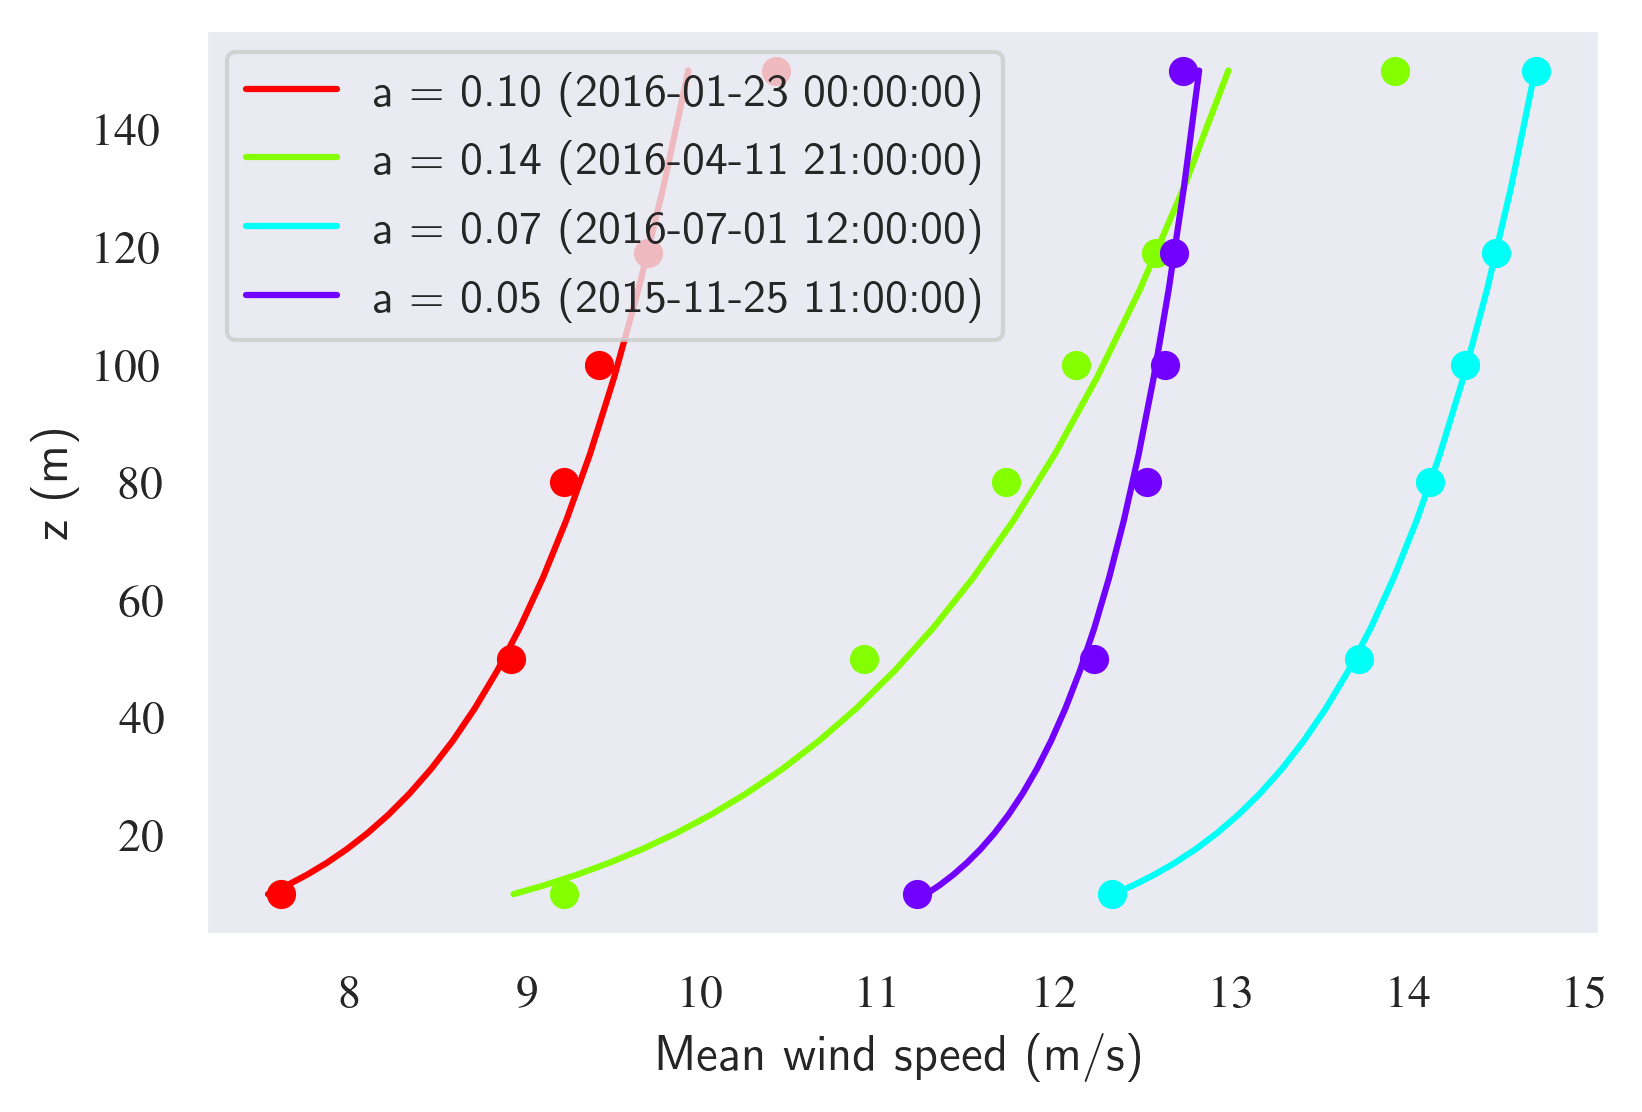

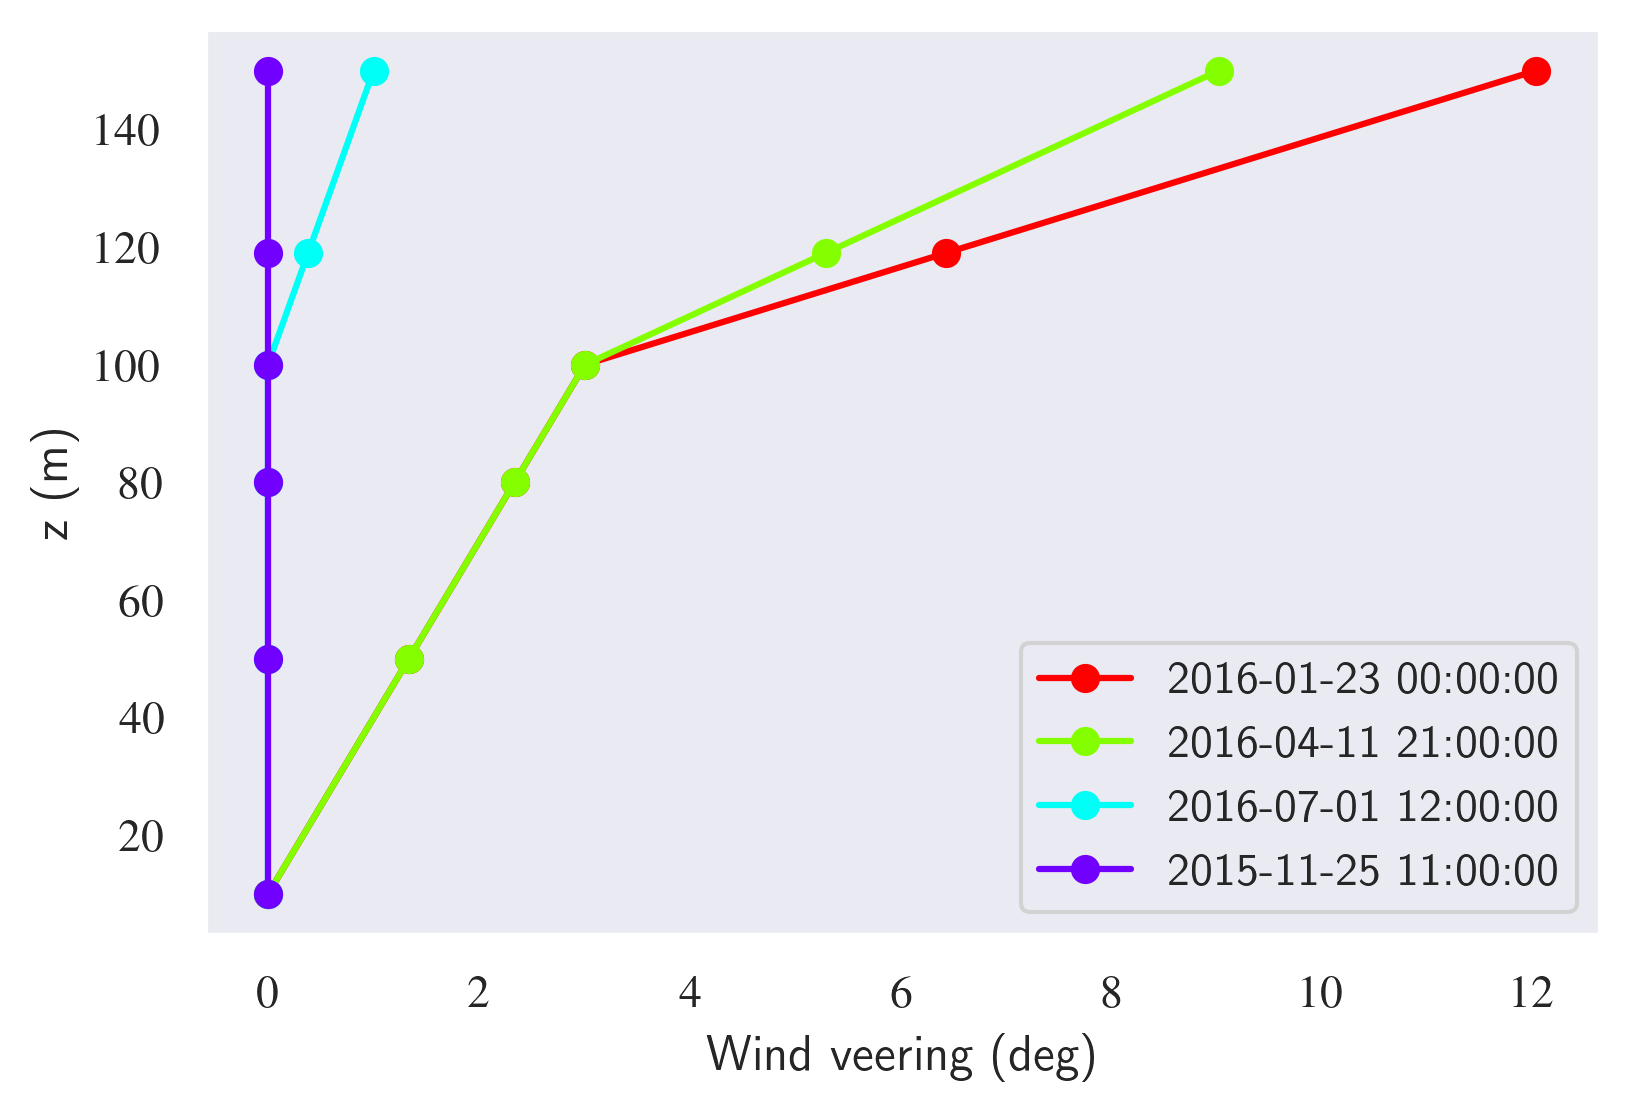

In [11]:
# %% Question 8

from scipy.optimize import curve_fit

d = pd.to_datetime(['2016-01-23 00:00','2016-04-11 21:00','2016-07-01 12:00','2015-11-25 11:00'])

def func(zr, a):
    ur = zr**a    
    return ur

def powerLaw(zHub,uHub,z, a):
    u = uHub*(z/zHub)**a    
    return u

cmap = plt.cm.hsv

# Power law check
fig = plt.figure()
for ii in range(len(d)):
    
    color = cmap(ii/len(d))  
    
    indTime  =  np.argmin(np.abs(pd_time-d[ii]))
    print(pd_time[indTime])
    plt.plot(newU[indTime,:],newZ,'o', color = color)
    
    ur = newU[indTime,:]/newU[indTime,indZ]
    zr = newZ/zHub
    alpha,dummy = curve_fit(func, zr,ur, bounds=(0, 1))
    mylabel2="a =  {:.2f}".format(float(alpha))
    myLabel1 = str(d[ii])

    z1 = np.logspace(np.log10(newZ[0]),np.log10(newZ[-1]),20)
    plt.plot(powerLaw(zHub,newU[indTime,indZ],z1,alpha),z1, color = color, label = mylabel2 + ' (' + myLabel1 + ')' )

plt.grid()    
plt.legend()
plt.xlabel("Mean wind speed (m/s)")
plt.ylabel("z (m)")

plt.savefig('figures/powerlaw.pdf')

# Wind veer check
fig = plt.figure()
for ii in range(len(d)):
    
    color = cmap(ii/len(d))  
    
    indTime  =  np.argmin(np.abs(pd_time-d[ii]))
    print(pd_time[indTime])
    myLabel1 = str(d[ii])
    plt.plot(newDir[indTime,:]-newDir[indTime,0],newZ,'o-', color = color, label = myLabel1 )
    
    
    
plt.grid()    
plt.legend()
plt.xlabel("Wind veering (deg)")
plt.ylabel("z (m)")


plt.savefig('figures/wind_veer.pdf')


# The power coefficient is lower than usually modelled offshore, which is 0.11


## Question 9:

In [12]:
# %% Question 9
# Air sea temperature difference

s = pd.read_csv('NORA10_T_5674N_0501E.txt', header=2, sep='\s+')

T100 = s["T100"]
SST = s["SST"]

s = np.array(s)
N = np.size(s[:,1])
t1=  datetime(int(s[0,0]),int(s[0,1]),int(s[0,2]),int(s[0,3]))
t2=  datetime(int(s[-1,0]),int(s[-1,1]),int(s[-1,2]),int(s[-1,3]))  
time = np.arange(t1,t2 + timedelta(hours=3) ,np.timedelta64(3, 'h'))
pd_time = pd.DatetimeIndex(time)

for ii in range(len(d)):
    indTime  =  np.argmin(np.abs(pd_time-d[ii]))
    dTemp = T100[indTime] - SST[indTime]
    mylabel = "On "+ str(pd_time[indTime]) + ", DT = {:.2f} degC".format(float(dTemp))
    if dTemp>0:
        print('The atmosphere is statically stable')
    else:
        print('The atmosphere is statically unstable')
        
    print(mylabel)
      

#Trykk celle og y for python, og m for markdown
#Trykk windows og v for flere kopier
#proofread at chat gpt

The atmosphere is statically stable
On 2016-01-23 00:00:00, DT = 0.10 degC
The atmosphere is statically stable
On 2016-04-11 21:00:00, DT = 1.00 degC
The atmosphere is statically unstable
On 2016-07-01 12:00:00, DT = -1.20 degC
The atmosphere is statically unstable
On 2015-11-25 12:00:00, DT = -2.90 degC
